In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import geopandas as gpd
from shapely.geometry import Polygon
from shapely import wkt
from shapely import wkb
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import matplotlib.patches as mpatches
from sentinelsat import SentinelAPI
import pandas as pd
from datetime import datetime
from datetime import date
import glob
from collections import OrderedDict
import os
import csv

import requests
import json
import getpass

from utils.prepS2 import *
from utils.utils import reproject_wkt_4326_3460

## Prep data sets

In [39]:
# Load all aois
aois_dir = "../DY/"
aois = [gpd.read_file(x) for x in glob.glob(aois_dir + '*.geojson')] # load aois
aois = gpd.GeoDataFrame(pd.concat(aois)) # spatial join aois

In [85]:
aois = gpd.read_file('../DY/DY_AoI.geojson')

In [56]:
# Load landsat & sentinel-2 world tiles
world_s2_granules = gpd.read_file('../Ancillary_Datasets/sentinel2_tiles_world/sentinel2_tiles_world.shp')
# world_ls_granules = gpd.read_file('../Ancillary_Datasets/WRS2_descending.shp')

In [57]:
world_borders = gpd.read_file('../Ancillary_Datasets/TM_WORLD_BORDERS-0.2/TM_WORLD_BORDERS-0.2.shp')
yem = world_borders.loc[world_borders.NAME == 'Yemen']

## Determine overlaping tiles

In [54]:
aois['NAME'] = 'DY'
aois

,id,geometry,NAME
0,None,"POLYGON ((4695185.890932178 1774596.816285792,...",DY


In [63]:
# Create bool for intersection between any tiles 
for n, g in zip(yem.NAME, yem.geometry):
#     world_ls_granules[n] = world_ls_granules.geometry.apply(lambda x: gpd.GeoSeries(x).intersects(g))
    world_s2_granules[n] = world_s2_granules.geometry.apply(lambda x: gpd.GeoSeries(x).intersects(g))


In [68]:
# Filter based on any intersections
# world_ls_granules['DY'] = world_ls_granules[world_ls_granules[aois.Name.values]].any(1)
# dy_ls_grans = world_ls_granules[world_ls_granules.DY==True]
world_s2_granules['Yemen'] = world_s2_granules[world_s2_granules[yem.NAME.values]].any(1)
dy_s2_grans = world_s2_granules[world_s2_granules.Yemen==True]

In [86]:
dy_s2_grans['AOI'] = dy_s2_grans.geometry.apply(lambda x: gpd.GeoSeries(x).intersects(aois))

/home/tj/miniconda3/envs/cs/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [87]:
aois_grans = dy_s2_grans[dy_s2_grans.AOI==True]

In [ ]:
world_s2_granules['Yemen'] = world_s2_granules[world_s2_granules[yem.NAME.values]].any(1)
dy_s2_grans = world_s2_granules[world_s2_granules.Yemen==True]

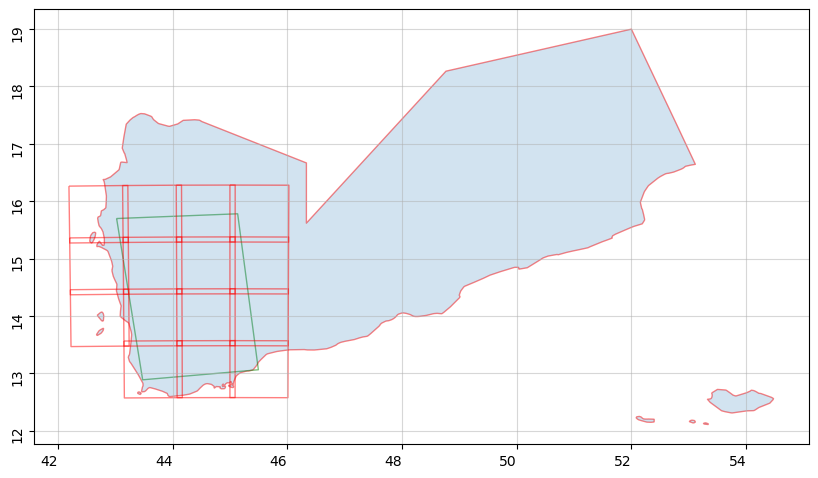

In [88]:
# Plot coverage
fig, ax = plt.subplots(figsize=(10,10),dpi=100)
fig.autofmt_xdate()
yem.plot(facecolor='', edgecolor='r', ax=ax, alpha=0.5)
aois.plot(facecolor='', edgecolor='g', ax=ax, alpha=0.5)

# dy_ls_grans.plot(facecolor='', edgecolor='b', ax=ax, alpha=0.75)
# dy_s2_grans.plot(facecolor='', edgecolor='g', ax=ax, alpha=0.75)
yem.plot(column = 'NAME', ax=ax, alpha=0.2);

aois_grans.plot(facecolor='', edgecolor='r', ax=ax, alpha=0.5)


ax.grid(alpha=0.5);
ax.tick_params(axis='y', rotation=90);
ax.tick_params(axis='x', rotation=0);

In [89]:
s2_tiles = list(aois_grans.Name.values)
len(s2_tiles)

15

In [90]:
gc = pd.read_csv('../Ancillary_Datasets/L2_index.csv.gz')
gc_yem = gc[ gc.MGRS_TILE.isin(s2_tiles) ]
gc = None

In [91]:
gc_fj = gc_yem

In [94]:
gc_fj = gc_fj.sort_values('CLOUD_COVER', ascending=True)
gc_fj = gc_fj[pd.notnull(gc_fj['TOTAL_SIZE'])]
gc_fj['sizeMB'] = gc_fj.TOTAL_SIZE/1024/1024

In [99]:
gc_fj.SENSING_TIME

559064     2019-01-11T07:45:16.000000Z
2131644    2019-06-05T07:45:19.000000Z
475746     2019-01-01T07:45:14.000000Z
2447812    2019-07-10T07:45:26.000000Z
1838693    2019-05-11T07:45:25.000000Z
                      ...             
2558246    2019-08-09T07:45:37.906000Z
2559252    2019-08-09T07:45:44.558000Z
1597258    2019-04-24T07:55:33.000000Z
2594582    2019-08-12T07:55:45.039000Z
2095939    2019-06-02T07:36:22.000000Z
Name: SENSING_TIME, Length: 1089, dtype: object

In [95]:
gc_fj.sizeMB.values[:5]

array([44.78181267, 50.45363808, 45.6585722 , 39.02363014, 40.5818367 ])

In [107]:
gc_fj.columns

Index(['GRANULE_ID', 'PRODUCT_ID', 'DATATAKE_IDENTIFIER', 'MGRS_TILE',
       'SENSING_TIME', 'TOTAL_SIZE', 'CLOUD_COVER', 'GEOMETRIC_QUALITY_FLAG',
       'GENERATION_TIME', 'NORTH_LAT', 'SOUTH_LAT', 'WEST_LON', 'EAST_LON',
       'BASE_URL', 'sizeMB'],
      dtype='object')

38PKA
2019-08-19T07:46:07.685000Z
2019-06-25T07:46:06.000000Z
2019-06-15T07:46:05.000000Z
2019-06-10T07:46:09.000000Z
2019-06-05T07:46:03.000000Z
2019-05-31T07:46:10.000000Z
2019-05-26T07:46:05.000000Z
2019-05-16T07:46:05.000000Z
2019-05-11T07:46:10.000000Z
2019-05-06T07:46:05.000000Z
38PKB
2019-08-24T07:45:49.205000Z
2019-08-19T07:45:53.037000Z
2019-08-17T07:55:41.251000Z
2019-08-04T07:45:51.682000Z
2019-07-10T07:45:56.000000Z
2019-07-08T07:55:43.000000Z
2019-07-03T07:55:46.000000Z
2019-06-25T07:45:51.000000Z
2019-06-23T07:55:46.000000Z
2019-06-18T07:55:42.000000Z
2019-06-15T07:45:50.000000Z
2019-06-13T07:55:45.000000Z
2019-06-10T07:45:54.000000Z
2019-06-05T07:45:49.000000Z
2019-06-03T07:55:46.000000Z
2019-05-31T07:46:04.000000Z
2019-05-31T07:45:55.000000Z
2019-05-29T07:55:41.000000Z
2019-05-26T07:45:50.000000Z
2019-05-24T07:55:46.000000Z
38PKC
2019-08-24T07:45:34.815000Z
2019-08-19T07:45:38.653000Z
2019-08-17T07:55:30.163000Z
2019-08-04T07:45:37.301000Z
2019-07-10T07:45:46.000000Z
20

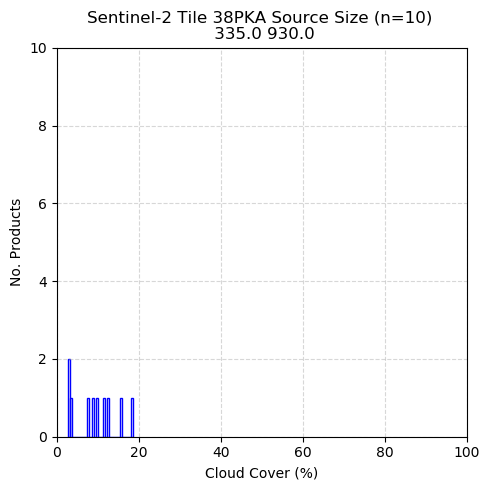

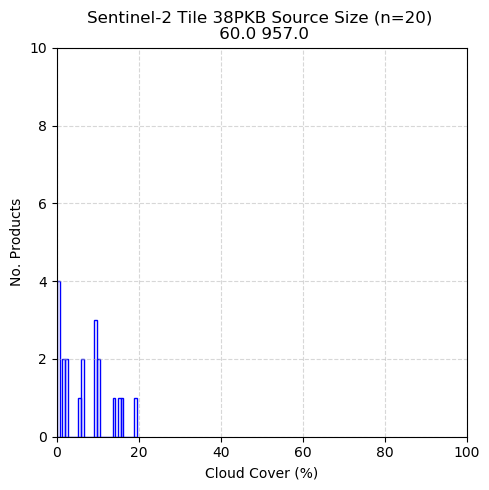

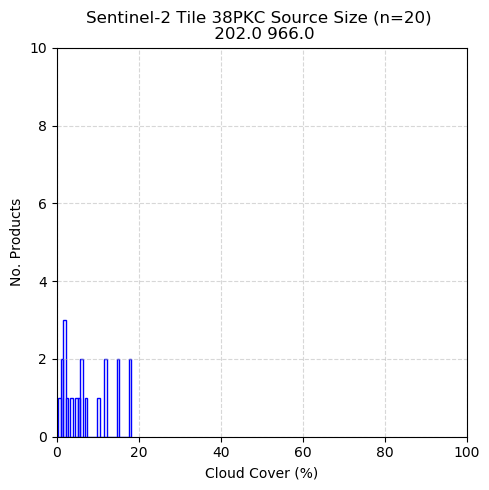

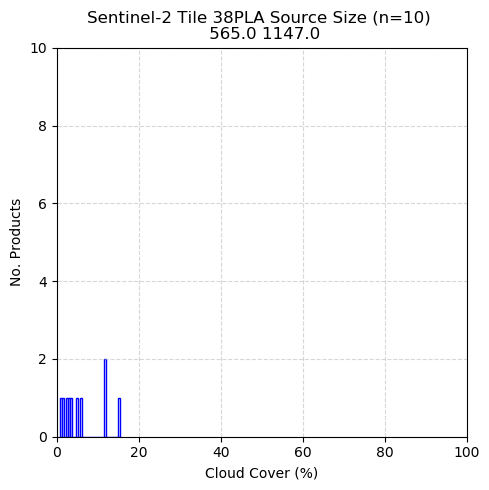

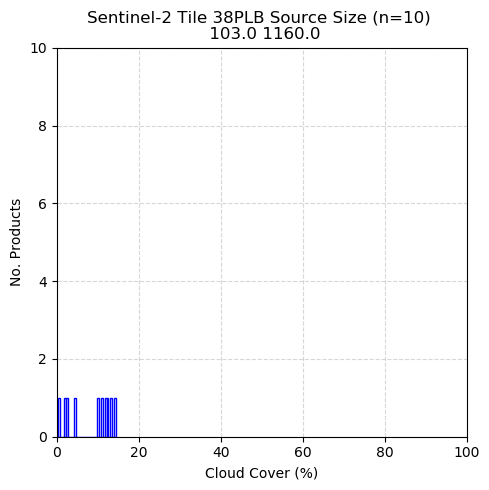

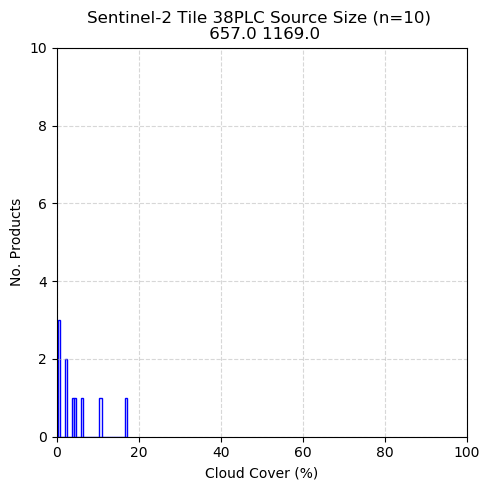

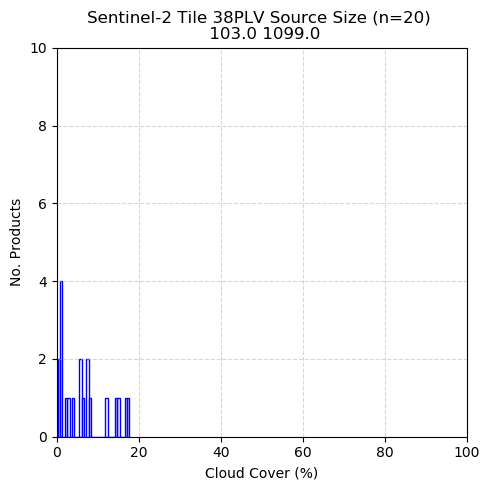

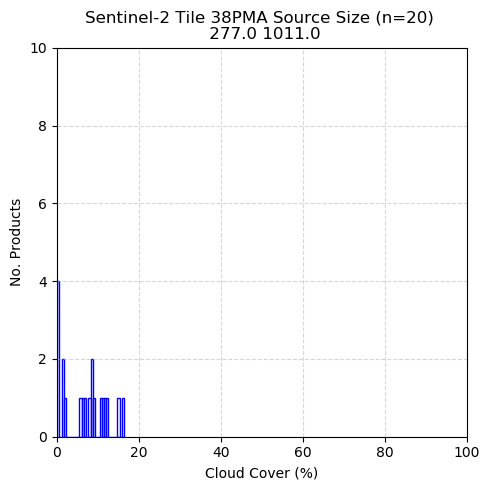

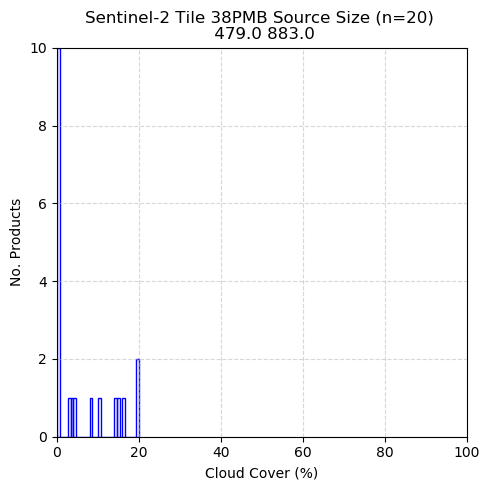

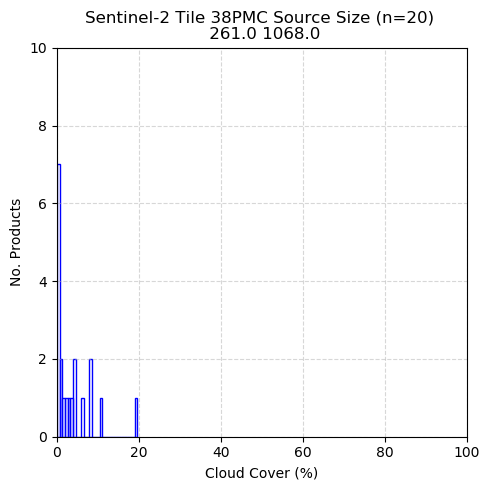

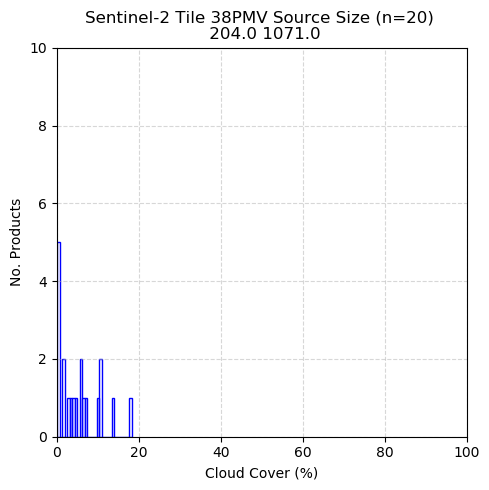

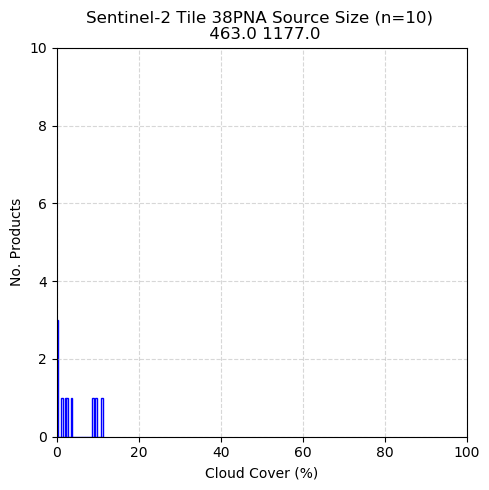

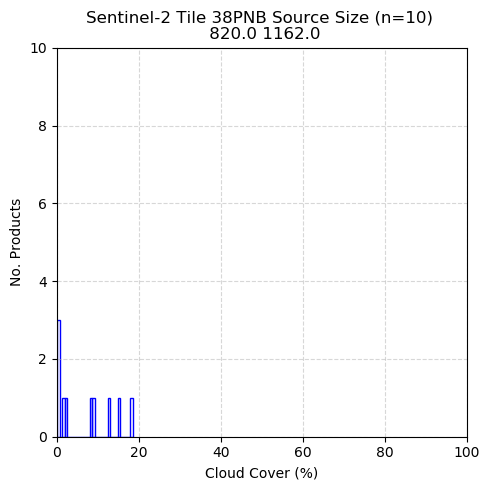

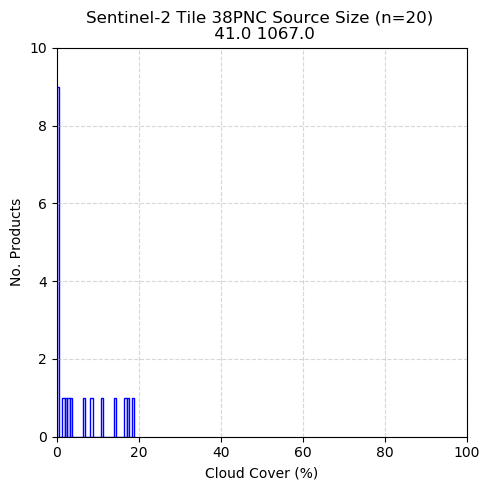

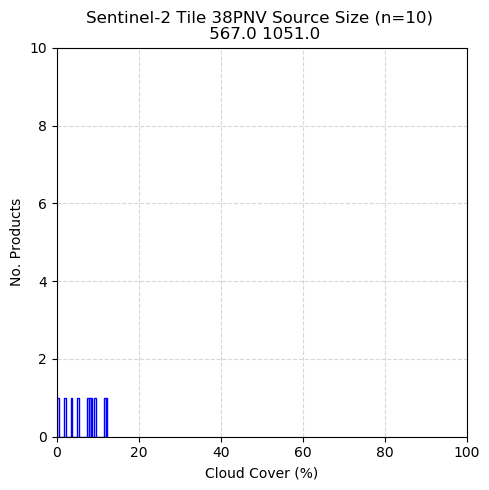

In [112]:
candidates = []


for t in s2_tiles[:]:
    df = gc_fj.loc[gc_fj.MGRS_TILE == t]
    sz = df.sizeMB.values
    
    gc_fj = gc_fj.sort_values('SENSING_TIME', ascending=False)

    fig, ax = plt.subplots(figsize=(5,5),dpi=100)
    
    df = df[df.CLOUD_COVER < 20]
    
    if df.shape[0] < 50:
        df = df.head(10)
    else:
        df = df.head(20)
    
    print(t)
    for i in df.SENSING_TIME.values: print(i)
        
    for sid in df.PRODUCT_ID: candidates.append(sid)
    
    df.hist(column='CLOUD_COVER', bins=30, color='b', edgecolor='b', fc='None', ax=ax)
    ax.grid(alpha=0.5, linestyle='--');
    ax.set_ylabel("No. Products");
    ax.set_xlabel("Cloud Cover (%)");
    ax.set_ylim(0,10)
    ax.set_xlim(0,100)
    ax.set_title("Sentinel-2 Tile {} Source Size (n={}) \n {} {}".format(
        t, df.shape[0], round(np.percentile(sz, 5),0), round(np.percentile(sz, 95),0)));
    fig.tight_layout();
    
    
#     print(df.CLOUD_COVER.values[:5],df.sizeMB.values[:5])

In [115]:
candidates

['S2B_MSIL2A_20190819T072619_N0213_R049_T38PKA_20190819T115802',
 'S2A_MSIL2A_20190625T072621_N0212_R049_T38PKA_20190625T104921',
 'S2A_MSIL2A_20190615T072621_N0212_R049_T38PKA_20190615T101308',
 'S2B_MSIL2A_20190610T072629_N0212_R049_T38PKA_20190610T111631',
 'S2A_MSIL2A_20190605T072621_N0212_R049_T38PKA_20190605T112203',
 'S2B_MSIL2A_20190531T072629_N0212_R049_T38PKA_20190531T112736',
 'S2A_MSIL2A_20190526T072621_N0212_R049_T38PKA_20190526T105049',
 'S2A_MSIL2A_20190516T072621_N0212_R049_T38PKA_20190516T105014',
 'S2B_MSIL2A_20190511T072629_N0212_R049_T38PKA_20190511T104810',
 'S2A_MSIL2A_20190506T072621_N0212_R049_T38PKA_20190506T104731',
 'S2A_MSIL2A_20190824T072621_N0213_R049_T38PKB_20190824T104722',
 'S2B_MSIL2A_20190819T072619_N0213_R049_T38PKB_20190819T115802',
 'S2A_MSIL2A_20190817T073621_N0213_R092_T38PKB_20190817T120133',
 'S2A_MSIL2A_20190804T072621_N0213_R049_T38PKB_20190804T105037',
 'S2B_MSIL2A_20190710T072629_N0213_R049_T38PKB_20190710T110035',
 'S2A_MSIL2A_20190708T073

## Determine availability of desired products

In [14]:
base = aois_dir
aoi = 'dy'

In [15]:
# Landsat
sensor = 'ls'
src = 'usgs'
pr = dy_ls_grans
df = pd.read_csv('../Ancillary_Datasets/LANDSAT_8_C1.csv.gz')
df = df[df.row.isin(pr.ROW.values)&df.path.isin(pr.PATH.values)]
# df.to_csv("{}{}_{}_{}_{}.csv".format(base, aoi, sensor, '8', src))
res3 = df

In [16]:
# Sentinel
esa_api = SentinelAPI('tmj21','Welcome12!')
sensor = 's2'
src = 'esa'

res1 = {}
res2 = {}
for g in aois.geometry.values:
    g = g.envelope.wkt
    res1.update(esa_api.query(g,platformname='Sentinel-2',producttype='S2MSI1C', date=('NOW-60DAYS', 'NOW')))
    res2.update(esa_api.query(g,platformname='Sentinel-2',producttype='S2MSI2A', date=('NOW-60DAYS', 'NOW')))

Querying products: 100%|██████████| 475/475 [00:04<00:00, 77.74 products/s]


In [17]:
res1 = esa_api.to_geodataframe(res1)
res2 = esa_api.to_geodataframe(res2)

In [18]:
res3['AcquisitionDate'] = pd.to_datetime(res3['acquisitionDate'], format='%Y-%m-%d')
res3 = res3[(res3.AcquisitionDate>date(2019,5,1)) & (res3.AcquisitionDate<date(2020,1,1))]

/home/tj/miniconda3/envs/cs/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  


In [19]:
res2['tileid'] = res2.apply(lambda row: row.title.split('_')[5][1:], axis=1)
# df['c'] = df.apply(lambda row: row.a + row.b, axis=1)

## Summary of availability

In [33]:
search_outputs_dir = aois_dir

/home/tj/miniconda3/envs/cs/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


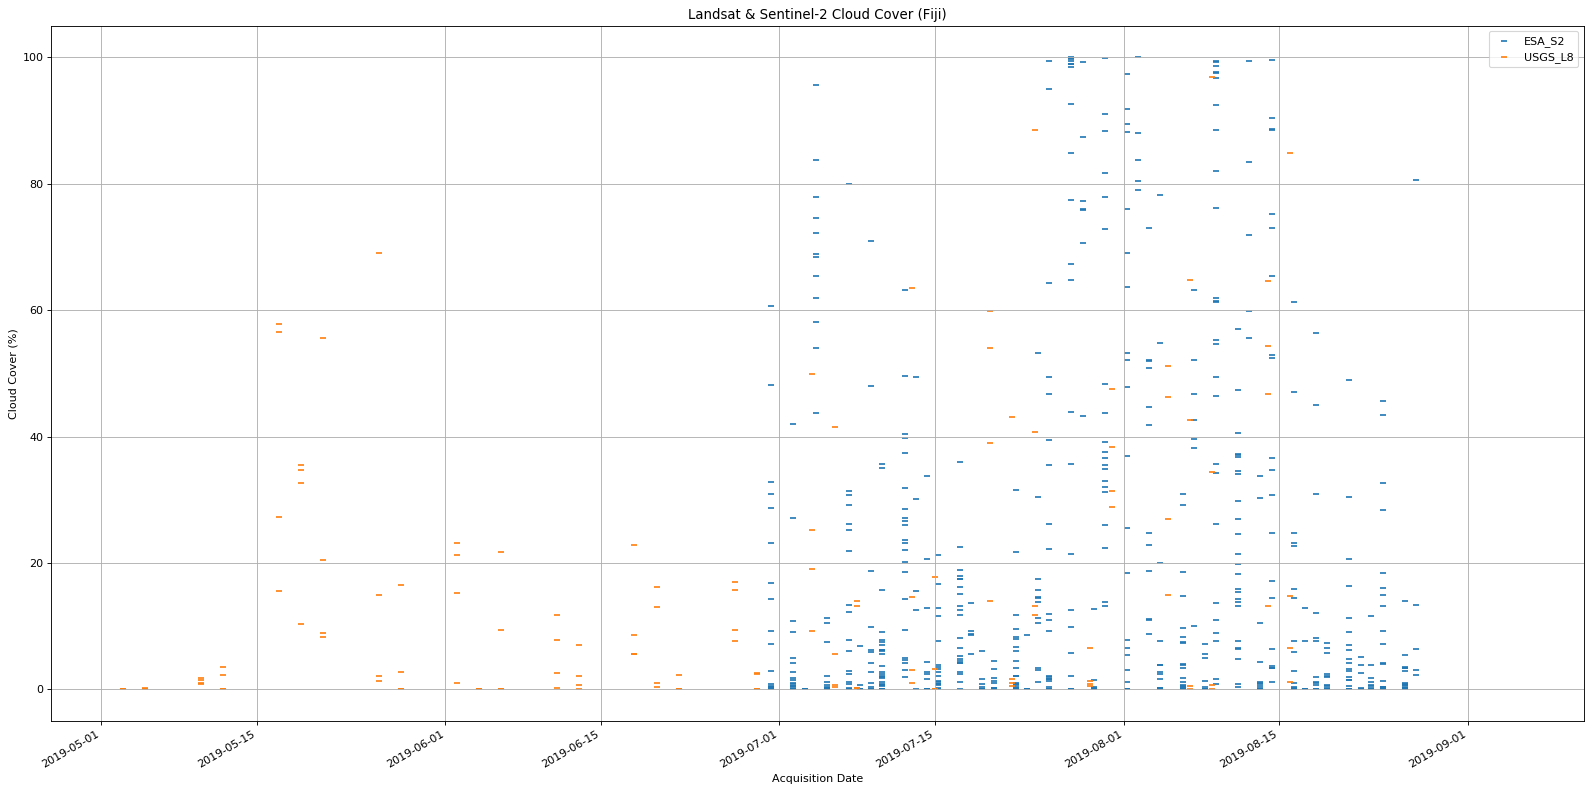

In [34]:
fig, ax = plt.subplots(figsize=(20,10),dpi=80)
fig.autofmt_xdate()

df = pd.read_csv(search_outputs_dir + 'dy_s2_l1c_esa.csv')
df['Acquisition Date'] = pd.to_datetime(df['beginposition'], format='%Y-%m-%d', utc=True)
ax.scatter(df['Acquisition Date'].values, df['cloudcoverpercentage'].values, marker='_');

ax.scatter(res3['AcquisitionDate'].values, res3.cloudCover.values, marker='_')

ax.set_ylabel("Cloud Cover (%)");
ax.set_xlabel("Acquisition Date");
ax.legend(['ESA_S2','USGS_L8','USGS_L7','USGS_L4-5TM','USGS_L1-4MSS']);
ax.set_title('Landsat & Sentinel-2 Cloud Cover (Fiji)');
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(DateFormatter("%Y-%m-%d") ) 
ax.xaxis.set_minor_locator(mdates.MonthLocator())
#ax.xaxis.set_minor_formatter(DateFormatter("%m") ) 
ax.grid(which='both')
fig.tight_layout()

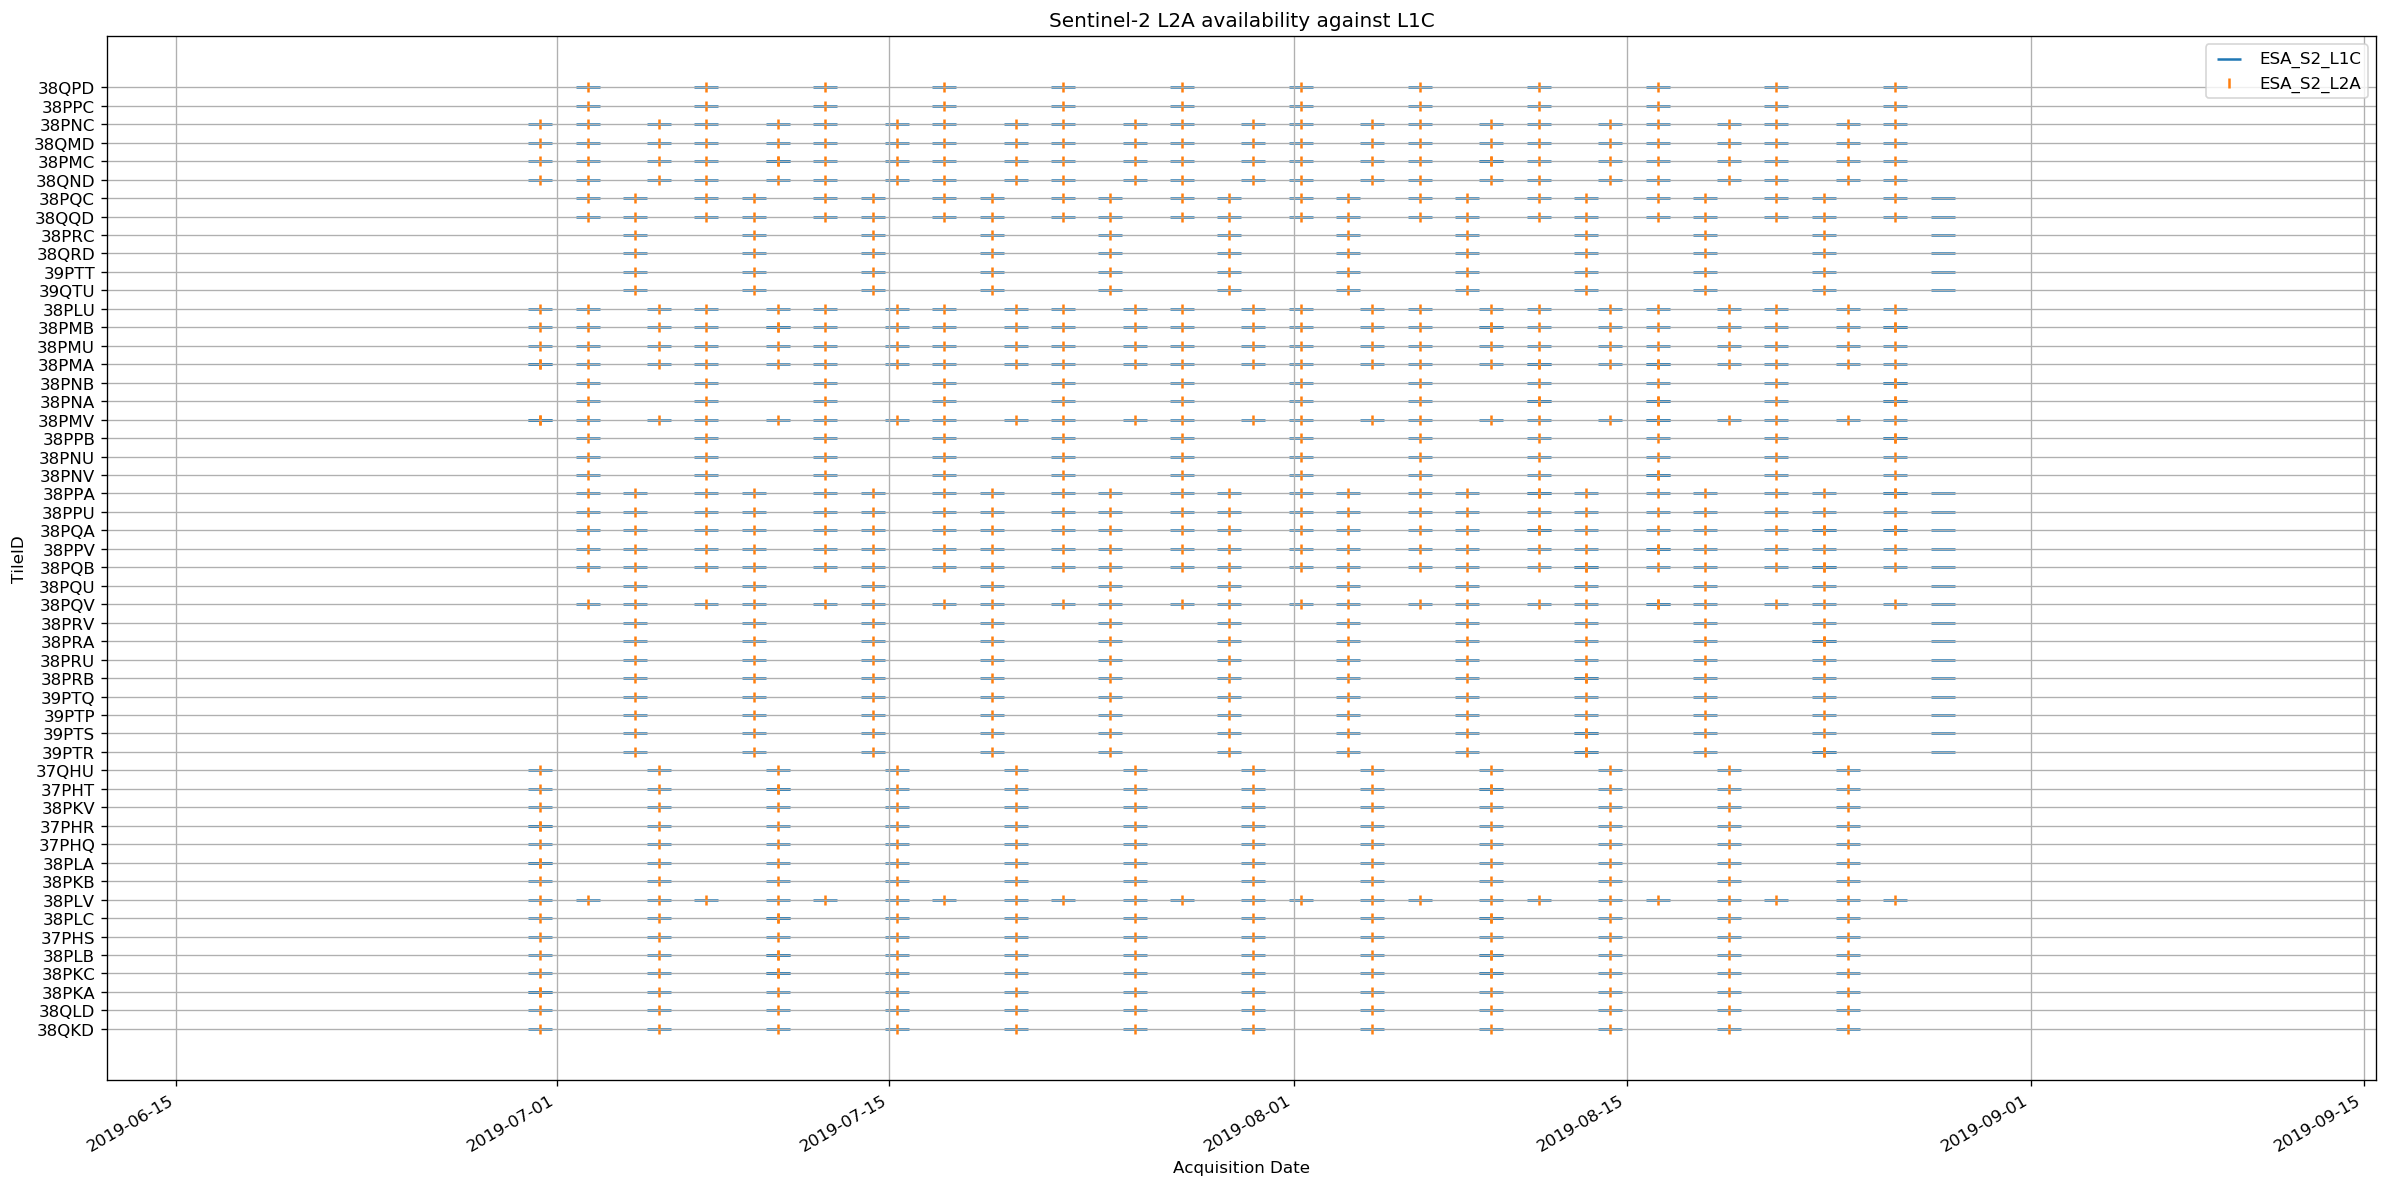

In [35]:
fig, ax = plt.subplots(figsize=(20,10),dpi=120)
fig.autofmt_xdate()

# df = pd.read_csv(search_outputs_dir + 'dy_s2_l1c_esa.csv')
df = res1
df['Acquisition Date'] = pd.to_datetime(df['beginposition'], format='%Y-%m-%d', utc=True)
ax.scatter(df['Acquisition Date'].values, df['tileid'].values, marker='_', s=200);

df = res2
# df = pd.read_csv(search_outputs_dir + 'dy_s2_l2a_esa.csv')
df['Acquisition Date'] = pd.to_datetime(df['beginposition'], format='%Y-%m-%d', utc=True)
ax.scatter(df['Acquisition Date'].values, df['tileid'].values, marker='|');

ax.set_ylabel("TileID");
ax.set_xlabel("Acquisition Date");
ax.legend(['ESA_S2_L1C','ESA_S2_L2A','USGS_L7','USGS_L4-5TM','USGS_L1-4MSS']);
ax.set_title('Sentinel-2 L2A availability against L1C');
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(DateFormatter("%Y-%m-%d") ) 
ax.xaxis.set_minor_locator(mdates.MonthLocator())
#ax.xaxis.set_minor_formatter(DateFormatter("%m") ) 
ax.grid(which='both')
fig.tight_layout()


## Download Sentinel-2

In [20]:
s2ids = res2.uuid.values
s2nms = [i +'.SAFE' for i in res2.title.values]
print('Sentinel-2:', len(s2ids))
print('Landsat-8:', len(res3))

# for i,n in zip(s2ids, s2nms):
#     print(i,n)

Sentinel-2: 860
Landsat-8: 136


In [28]:
non_cogs_dir = "../DY/L2A/"
cogs_dir = "../DY/COGS/"
log_file = "./processLog.csv"

In [37]:

with open(log_file, 'a') as log:
    
    for des_scene in s2nms[8:40]:
        log.write("{},{},{}".format(des_scene, 'Starting', str(datetime.today().strftime('%Y-%m-%d %H:%M:%S'))))
        log.write("\n")
        # shorten scene name
        scene_name = des_scene[:-21]
        scene_name = scene_name[:-17] + scene_name.split('_')[-1]
        print ( 'Scene name: {}'.format(scene_name) )
        print ( 'Time: {}'.format(str(datetime.today().strftime('%Y-%m-%d %H:%M:%S'))) )

        # find uuid for download via esa hub
        s2id = find_s2_uuid(des_scene)

        down_dir = non_cogs_dir + des_scene + '/'
        print ( 'Download scene dir: {}'.format(down_dir) )
        print ( 'Time: {}'.format(str(datetime.today().strftime('%Y-%m-%d %H:%M:%S'))) )
        #download_s2_granule_gcloud(des_scene, non_cogs_dir)
        download_extract_s2_esa(s2id, non_cogs_dir, down_dir) # using esa due to gcloud metadata issues + sedas confidence

        log.write("{},{},{}".format(des_scene, 'Downloaded', str(datetime.today().strftime('%Y-%m-%d %H:%M:%S'))))
        log.write("\n")

        print ( 'Time: {}'.format(str(datetime.today().strftime('%Y-%m-%d %H:%M:%S'))) )

        # convert to cog
        cog_dir = cogs_dir + scene_name + '/'
        print ( 'COG dir: {}'.format(cog_dir) )
        conv_s2scene_cogs(down_dir, cog_dir, scene_name, 
                          ["B04_10m","B03_10m","B02_10m","B08_10m"])

        print ( 'Time: {}'.format(str(datetime.today().strftime('%Y-%m-%d %H:%M:%S'))) )
        log.write("{},{},{}".format(des_scene, 'COGGED', str(datetime.today().strftime('%Y-%m-%d %H:%M:%S'))))
        log.write("\n")

        s2_ndvi(glob.glob(cog_dir + '*4_10m.tif')[0],glob.glob(cog_dir + '*8_10m.tif')[0])

        log.write("{},{},{}".format(des_scene, 'NDVIID', str(datetime.today().strftime('%Y-%m-%d %H:%M:%S'))))
        log.write("\n")
    
        print ( 'Time: {}'.format(str(datetime.today().strftime('%Y-%m-%d %H:%M:%S'))) )


Scene name: S2A_MSIL2A_20190824T072621_T38PKB
Time: 2019-08-28 20:48:03
Download scene dir: ../DY/L2A/S2A_MSIL2A_20190824T072621_N0213_R049_T38PKB_20190824T104722.SAFE/
Time: 2019-08-28 20:48:04
ESA scene already extracted: ../DY/L2A/S2A_MSIL2A_20190824T072621_N0213_R049_T38PKB_20190824T104722.SAFE/
Time: 2019-08-28 20:48:04
COG dir: ../DY/COGS/S2A_MSIL2A_20190824T072621_T38PKB/
cog already exists: ../DY/COGS/S2A_MSIL2A_20190824T072621_T38PKB/S2A_MSIL2A_20190824T072621_T38PKB_B02_10m.tif
cog already exists: ../DY/COGS/S2A_MSIL2A_20190824T072621_T38PKB/S2A_MSIL2A_20190824T072621_T38PKB_B03_10m.tif
cog already exists: ../DY/COGS/S2A_MSIL2A_20190824T072621_T38PKB/S2A_MSIL2A_20190824T072621_T38PKB_B04_10m.tif
cog already exists: ../DY/COGS/S2A_MSIL2A_20190824T072621_T38PKB/S2A_MSIL2A_20190824T072621_T38PKB_B08_10m.tif
Time: 2019-08-28 20:48:04
../DY/COGS/S2A_MSIL2A_20190824T072621_T38PKB/S2A_MSIL2A_20190824T072621_T38PKB_NDVI_10m_inter.tif ../DY/COGS/S2A_MSIL2A_20190824T072621_T38PKB/S2A_M

Downloading: 100%|██████████| 857M/857M [18:33<00:00, 565kB/s]   
MD5 checksumming: 100%|██████████| 857M/857M [00:02<00:00, 315MB/s] 


Extracting ESA scene: ../DY/L2A/S2A_MSIL2A_20190824T072621_N0213_R049_T38PKA_20190824T104722.SAFE/
Deleting ESA scene zip: ../DY/L2A/S2A_MSIL2A_20190824T072621_N0213_R049_T38PKA_20190824T104722.zip
Time: 2019-08-28 21:07:51
COG dir: ../DY/COGS/S2A_MSIL2A_20190824T072621_T38PKA/
Creating scene cog directory: ../DY/COGS/S2A_MSIL2A_20190824T072621_T38PKA/
../DY/L2A/S2A_MSIL2A_20190824T072621_N0213_R049_T38PKA_20190824T104722.SAFE/GRANULE/L2A_T38PKA_A021782_20190824T074108/IMG_DATA/R10m/T38PKA_20190824T072621_B02_10m.jp2 ../DY/COGS/S2A_MSIL2A_20190824T072621_T38PKA/S2A_MSIL2A_20190824T072621_T38PKA_B02_10m.tif
../DY/L2A/S2A_MSIL2A_20190824T072621_N0213_R049_T38PKA_20190824T104722.SAFE/GRANULE/L2A_T38PKA_A021782_20190824T074108/IMG_DATA/R10m/T38PKA_20190824T072621_B03_10m.jp2 ../DY/COGS/S2A_MSIL2A_20190824T072621_T38PKA/S2A_MSIL2A_20190824T072621_T38PKA_B03_10m.tif
../DY/L2A/S2A_MSIL2A_20190824T072621_N0213_R049_T38PKA_20190824T104722.SAFE/GRANULE/L2A_T38PKA_A021782_20190824T074108/IMG_DATA

Downloading: 100%|██████████| 529M/529M [09:42<00:00, 601kB/s]  
MD5 checksumming: 100%|██████████| 529M/529M [00:01<00:00, 272MB/s] 


Extracting ESA scene: ../DY/L2A/S2A_MSIL2A_20190824T072621_N0213_R049_T37PHT_20190824T104722.SAFE/
Deleting ESA scene zip: ../DY/L2A/S2A_MSIL2A_20190824T072621_N0213_R049_T37PHT_20190824T104722.zip
Time: 2019-08-28 21:21:35
COG dir: ../DY/COGS/S2A_MSIL2A_20190824T072621_T37PHT/
Creating scene cog directory: ../DY/COGS/S2A_MSIL2A_20190824T072621_T37PHT/
../DY/L2A/S2A_MSIL2A_20190824T072621_N0213_R049_T37PHT_20190824T104722.SAFE/GRANULE/L2A_T37PHT_A021782_20190824T074108/IMG_DATA/R10m/T37PHT_20190824T072621_B02_10m.jp2 ../DY/COGS/S2A_MSIL2A_20190824T072621_T37PHT/S2A_MSIL2A_20190824T072621_T37PHT_B02_10m.tif
../DY/L2A/S2A_MSIL2A_20190824T072621_N0213_R049_T37PHT_20190824T104722.SAFE/GRANULE/L2A_T37PHT_A021782_20190824T074108/IMG_DATA/R10m/T37PHT_20190824T072621_B03_10m.jp2 ../DY/COGS/S2A_MSIL2A_20190824T072621_T37PHT/S2A_MSIL2A_20190824T072621_T37PHT_B03_10m.tif
../DY/L2A/S2A_MSIL2A_20190824T072621_N0213_R049_T37PHT_20190824T104722.SAFE/GRANULE/L2A_T37PHT_A021782_20190824T074108/IMG_DATA

Downloading: 100%|██████████| 440M/440M [08:23<00:00, 283kB/s]  
MD5 checksumming: 100%|██████████| 440M/440M [00:01<00:00, 289MB/s] 


Extracting ESA scene: ../DY/L2A/S2A_MSIL2A_20190824T072621_N0213_R049_T37QHU_20190824T104722.SAFE/
Deleting ESA scene zip: ../DY/L2A/S2A_MSIL2A_20190824T072621_N0213_R049_T37QHU_20190824T104722.zip
Time: 2019-08-28 21:33:16
COG dir: ../DY/COGS/S2A_MSIL2A_20190824T072621_T37QHU/
Creating scene cog directory: ../DY/COGS/S2A_MSIL2A_20190824T072621_T37QHU/
../DY/L2A/S2A_MSIL2A_20190824T072621_N0213_R049_T37QHU_20190824T104722.SAFE/GRANULE/L2A_T37QHU_A021782_20190824T074108/IMG_DATA/R10m/T37QHU_20190824T072621_B02_10m.jp2 ../DY/COGS/S2A_MSIL2A_20190824T072621_T37QHU/S2A_MSIL2A_20190824T072621_T37QHU_B02_10m.tif
../DY/L2A/S2A_MSIL2A_20190824T072621_N0213_R049_T37QHU_20190824T104722.SAFE/GRANULE/L2A_T37QHU_A021782_20190824T074108/IMG_DATA/R10m/T37QHU_20190824T072621_B03_10m.jp2 ../DY/COGS/S2A_MSIL2A_20190824T072621_T37QHU/S2A_MSIL2A_20190824T072621_T37QHU_B03_10m.tif
../DY/L2A/S2A_MSIL2A_20190824T072621_N0213_R049_T37QHU_20190824T104722.SAFE/GRANULE/L2A_T37QHU_A021782_20190824T074108/IMG_DATA

Downloading: 100%|██████████| 1.01G/1.01G [18:09<00:00, 924kB/s] 
MD5 checksumming: 100%|██████████| 1.01G/1.01G [00:03<00:00, 307MB/s]


Extracting ESA scene: ../DY/L2A/S2A_MSIL2A_20190824T072621_N0213_R049_T37PHQ_20190824T104722.SAFE/
Deleting ESA scene zip: ../DY/L2A/S2A_MSIL2A_20190824T072621_N0213_R049_T37PHQ_20190824T104722.zip
Time: 2019-08-28 21:54:12
COG dir: ../DY/COGS/S2A_MSIL2A_20190824T072621_T37PHQ/
Creating scene cog directory: ../DY/COGS/S2A_MSIL2A_20190824T072621_T37PHQ/
../DY/L2A/S2A_MSIL2A_20190824T072621_N0213_R049_T37PHQ_20190824T104722.SAFE/GRANULE/L2A_T37PHQ_A021782_20190824T074108/IMG_DATA/R10m/T37PHQ_20190824T072621_B02_10m.jp2 ../DY/COGS/S2A_MSIL2A_20190824T072621_T37PHQ/S2A_MSIL2A_20190824T072621_T37PHQ_B02_10m.tif
../DY/L2A/S2A_MSIL2A_20190824T072621_N0213_R049_T37PHQ_20190824T104722.SAFE/GRANULE/L2A_T37PHQ_A021782_20190824T074108/IMG_DATA/R10m/T37PHQ_20190824T072621_B03_10m.jp2 ../DY/COGS/S2A_MSIL2A_20190824T072621_T37PHQ/S2A_MSIL2A_20190824T072621_T37PHQ_B03_10m.tif
../DY/L2A/S2A_MSIL2A_20190824T072621_N0213_R049_T37PHQ_20190824T104722.SAFE/GRANULE/L2A_T37PHQ_A021782_20190824T074108/IMG_DATA

Downloading: 100%|██████████| 832M/832M [17:36<00:00, 916kB/s]  
MD5 checksumming: 100%|██████████| 832M/832M [00:03<00:00, 256MB/s] 


Extracting ESA scene: ../DY/L2A/S2A_MSIL2A_20190824T072621_N0213_R049_T37PHR_20190824T104722.SAFE/
Deleting ESA scene zip: ../DY/L2A/S2A_MSIL2A_20190824T072621_N0213_R049_T37PHR_20190824T104722.zip
Time: 2019-08-28 22:16:12
COG dir: ../DY/COGS/S2A_MSIL2A_20190824T072621_T37PHR/
Creating scene cog directory: ../DY/COGS/S2A_MSIL2A_20190824T072621_T37PHR/
../DY/L2A/S2A_MSIL2A_20190824T072621_N0213_R049_T37PHR_20190824T104722.SAFE/GRANULE/L2A_T37PHR_A021782_20190824T074108/IMG_DATA/R10m/T37PHR_20190824T072621_B02_10m.jp2 ../DY/COGS/S2A_MSIL2A_20190824T072621_T37PHR/S2A_MSIL2A_20190824T072621_T37PHR_B02_10m.tif
../DY/L2A/S2A_MSIL2A_20190824T072621_N0213_R049_T37PHR_20190824T104722.SAFE/GRANULE/L2A_T37PHR_A021782_20190824T074108/IMG_DATA/R10m/T37PHR_20190824T072621_B03_10m.jp2 ../DY/COGS/S2A_MSIL2A_20190824T072621_T37PHR/S2A_MSIL2A_20190824T072621_T37PHR_B03_10m.tif
../DY/L2A/S2A_MSIL2A_20190824T072621_N0213_R049_T37PHR_20190824T104722.SAFE/GRANULE/L2A_T37PHR_A021782_20190824T074108/IMG_DATA

Downloading: 100%|██████████| 691M/691M [17:43<00:00, 526kB/s]  
MD5 checksumming: 100%|██████████| 691M/691M [00:02<00:00, 281MB/s] 


Extracting ESA scene: ../DY/L2A/S2A_MSIL2A_20190824T072621_N0213_R049_T37PHS_20190824T104722.SAFE/
Deleting ESA scene zip: ../DY/L2A/S2A_MSIL2A_20190824T072621_N0213_R049_T37PHS_20190824T104722.zip
Time: 2019-08-28 22:38:21
COG dir: ../DY/COGS/S2A_MSIL2A_20190824T072621_T37PHS/
Creating scene cog directory: ../DY/COGS/S2A_MSIL2A_20190824T072621_T37PHS/
../DY/L2A/S2A_MSIL2A_20190824T072621_N0213_R049_T37PHS_20190824T104722.SAFE/GRANULE/L2A_T37PHS_A021782_20190824T074108/IMG_DATA/R10m/T37PHS_20190824T072621_B02_10m.jp2 ../DY/COGS/S2A_MSIL2A_20190824T072621_T37PHS/S2A_MSIL2A_20190824T072621_T37PHS_B02_10m.tif
../DY/L2A/S2A_MSIL2A_20190824T072621_N0213_R049_T37PHS_20190824T104722.SAFE/GRANULE/L2A_T37PHS_A021782_20190824T074108/IMG_DATA/R10m/T37PHS_20190824T072621_B03_10m.jp2 ../DY/COGS/S2A_MSIL2A_20190824T072621_T37PHS/S2A_MSIL2A_20190824T072621_T37PHS_B03_10m.tif
../DY/L2A/S2A_MSIL2A_20190824T072621_N0213_R049_T37PHS_20190824T104722.SAFE/GRANULE/L2A_T37PHS_A021782_20190824T074108/IMG_DATA

Downloading: 100%|██████████| 940M/940M [16:55<00:00, 580kB/s]  
MD5 checksumming: 100%|██████████| 940M/940M [00:04<00:00, 233MB/s] 


Extracting ESA scene: ../DY/L2A/S2B_MSIL2A_20190819T072619_N0213_R049_T38PKV_20190819T115802.SAFE/
Deleting ESA scene zip: ../DY/L2A/S2B_MSIL2A_20190819T072619_N0213_R049_T38PKV_20190819T115802.zip
Time: 2019-08-28 22:59:04
COG dir: ../DY/COGS/S2B_MSIL2A_20190819T072619_T38PKV/
Creating scene cog directory: ../DY/COGS/S2B_MSIL2A_20190819T072619_T38PKV/
../DY/L2A/S2B_MSIL2A_20190819T072619_N0213_R049_T38PKV_20190819T115802.SAFE/GRANULE/L2A_T38PKV_A012802_20190819T074242/IMG_DATA/R10m/T38PKV_20190819T072619_B02_10m.jp2 ../DY/COGS/S2B_MSIL2A_20190819T072619_T38PKV/S2B_MSIL2A_20190819T072619_T38PKV_B02_10m.tif
../DY/L2A/S2B_MSIL2A_20190819T072619_N0213_R049_T38PKV_20190819T115802.SAFE/GRANULE/L2A_T38PKV_A012802_20190819T074242/IMG_DATA/R10m/T38PKV_20190819T072619_B03_10m.jp2 ../DY/COGS/S2B_MSIL2A_20190819T072619_T38PKV/S2B_MSIL2A_20190819T072619_T38PKV_B03_10m.tif
../DY/L2A/S2B_MSIL2A_20190819T072619_N0213_R049_T38PKV_20190819T115802.SAFE/GRANULE/L2A_T38PKV_A012802_20190819T074242/IMG_DATA

Downloading: 100%|██████████| 1.20G/1.20G [19:51<00:00, 1.13MB/s]
MD5 checksumming: 100%|██████████| 1.20G/1.20G [00:04<00:00, 249MB/s]


Extracting ESA scene: ../DY/L2A/S2B_MSIL2A_20190819T072619_N0213_R049_T38PLC_20190819T115802.SAFE/
Deleting ESA scene zip: ../DY/L2A/S2B_MSIL2A_20190819T072619_N0213_R049_T38PLC_20190819T115802.zip
Time: 2019-08-28 23:23:25
COG dir: ../DY/COGS/S2B_MSIL2A_20190819T072619_T38PLC/
Creating scene cog directory: ../DY/COGS/S2B_MSIL2A_20190819T072619_T38PLC/
../DY/L2A/S2B_MSIL2A_20190819T072619_N0213_R049_T38PLC_20190819T115802.SAFE/GRANULE/L2A_T38PLC_A012802_20190819T074242/IMG_DATA/R10m/T38PLC_20190819T072619_B02_10m.jp2 ../DY/COGS/S2B_MSIL2A_20190819T072619_T38PLC/S2B_MSIL2A_20190819T072619_T38PLC_B02_10m.tif
../DY/L2A/S2B_MSIL2A_20190819T072619_N0213_R049_T38PLC_20190819T115802.SAFE/GRANULE/L2A_T38PLC_A012802_20190819T074242/IMG_DATA/R10m/T38PLC_20190819T072619_B03_10m.jp2 ../DY/COGS/S2B_MSIL2A_20190819T072619_T38PLC/S2B_MSIL2A_20190819T072619_T38PLC_B03_10m.tif
../DY/L2A/S2B_MSIL2A_20190819T072619_N0213_R049_T38PLC_20190819T115802.SAFE/GRANULE/L2A_T38PLC_A012802_20190819T074242/IMG_DATA

Downloading: 100%|██████████| 1.18G/1.18G [20:33<00:00, 834kB/s] 
MD5 checksumming: 100%|██████████| 1.18G/1.18G [00:05<00:00, 213MB/s]


Extracting ESA scene: ../DY/L2A/S2B_MSIL2A_20190819T072619_N0213_R049_T38QLD_20190819T115802.SAFE/
Deleting ESA scene zip: ../DY/L2A/S2B_MSIL2A_20190819T072619_N0213_R049_T38QLD_20190819T115802.zip
Time: 2019-08-28 23:47:33
COG dir: ../DY/COGS/S2B_MSIL2A_20190819T072619_T38QLD/
Creating scene cog directory: ../DY/COGS/S2B_MSIL2A_20190819T072619_T38QLD/
../DY/L2A/S2B_MSIL2A_20190819T072619_N0213_R049_T38QLD_20190819T115802.SAFE/GRANULE/L2A_T38QLD_A012802_20190819T074242/IMG_DATA/R10m/T38QLD_20190819T072619_B02_10m.jp2 ../DY/COGS/S2B_MSIL2A_20190819T072619_T38QLD/S2B_MSIL2A_20190819T072619_T38QLD_B02_10m.tif
../DY/L2A/S2B_MSIL2A_20190819T072619_N0213_R049_T38QLD_20190819T115802.SAFE/GRANULE/L2A_T38QLD_A012802_20190819T074242/IMG_DATA/R10m/T38QLD_20190819T072619_B03_10m.jp2 ../DY/COGS/S2B_MSIL2A_20190819T072619_T38QLD/S2B_MSIL2A_20190819T072619_T38QLD_B03_10m.tif
../DY/L2A/S2B_MSIL2A_20190819T072619_N0213_R049_T38QLD_20190819T115802.SAFE/GRANULE/L2A_T38QLD_A012802_20190819T074242/IMG_DATA

Downloading: 100%|██████████| 1.22G/1.22G [21:55<00:00, 856kB/s] 
MD5 checksumming: 100%|██████████| 1.22G/1.22G [00:05<00:00, 231MB/s]


Extracting ESA scene: ../DY/L2A/S2B_MSIL2A_20190819T072619_N0213_R049_T38PLB_20190819T115802.SAFE/
Deleting ESA scene zip: ../DY/L2A/S2B_MSIL2A_20190819T072619_N0213_R049_T38PLB_20190819T115802.zip
Time: 2019-08-29 00:13:03
COG dir: ../DY/COGS/S2B_MSIL2A_20190819T072619_T38PLB/
Creating scene cog directory: ../DY/COGS/S2B_MSIL2A_20190819T072619_T38PLB/
../DY/L2A/S2B_MSIL2A_20190819T072619_N0213_R049_T38PLB_20190819T115802.SAFE/GRANULE/L2A_T38PLB_A012802_20190819T074242/IMG_DATA/R10m/T38PLB_20190819T072619_B02_10m.jp2 ../DY/COGS/S2B_MSIL2A_20190819T072619_T38PLB/S2B_MSIL2A_20190819T072619_T38PLB_B02_10m.tif
../DY/L2A/S2B_MSIL2A_20190819T072619_N0213_R049_T38PLB_20190819T115802.SAFE/GRANULE/L2A_T38PLB_A012802_20190819T074242/IMG_DATA/R10m/T38PLB_20190819T072619_B03_10m.jp2 ../DY/COGS/S2B_MSIL2A_20190819T072619_T38PLB/S2B_MSIL2A_20190819T072619_T38PLB_B03_10m.tif
../DY/L2A/S2B_MSIL2A_20190819T072619_N0213_R049_T38PLB_20190819T115802.SAFE/GRANULE/L2A_T38PLB_A012802_20190819T074242/IMG_DATA

Downloading: 100%|██████████| 1.08G/1.08G [18:50<00:00, 861kB/s] 
MD5 checksumming: 100%|██████████| 1.08G/1.08G [00:04<00:00, 229MB/s]


Extracting ESA scene: ../DY/L2A/S2B_MSIL2A_20190819T072619_N0213_R049_T38PLV_20190819T115802.SAFE/
Deleting ESA scene zip: ../DY/L2A/S2B_MSIL2A_20190819T072619_N0213_R049_T38PLV_20190819T115802.zip
Time: 2019-08-29 00:35:14
COG dir: ../DY/COGS/S2B_MSIL2A_20190819T072619_T38PLV/
Creating scene cog directory: ../DY/COGS/S2B_MSIL2A_20190819T072619_T38PLV/
../DY/L2A/S2B_MSIL2A_20190819T072619_N0213_R049_T38PLV_20190819T115802.SAFE/GRANULE/L2A_T38PLV_A012802_20190819T074242/IMG_DATA/R10m/T38PLV_20190819T072619_B02_10m.jp2 ../DY/COGS/S2B_MSIL2A_20190819T072619_T38PLV/S2B_MSIL2A_20190819T072619_T38PLV_B02_10m.tif
../DY/L2A/S2B_MSIL2A_20190819T072619_N0213_R049_T38PLV_20190819T115802.SAFE/GRANULE/L2A_T38PLV_A012802_20190819T074242/IMG_DATA/R10m/T38PLV_20190819T072619_B03_10m.jp2 ../DY/COGS/S2B_MSIL2A_20190819T072619_T38PLV/S2B_MSIL2A_20190819T072619_T38PLV_B03_10m.tif
../DY/L2A/S2B_MSIL2A_20190819T072619_N0213_R049_T38PLV_20190819T115802.SAFE/GRANULE/L2A_T38PLV_A012802_20190819T074242/IMG_DATA

Downloading: 100%|██████████| 871M/871M [13:14<00:00, 981kB/s]  
MD5 checksumming: 100%|██████████| 871M/871M [00:03<00:00, 230MB/s] 


Extracting ESA scene: ../DY/L2A/S2B_MSIL2A_20190819T072619_N0213_R049_T38QKD_20190819T115802.SAFE/
Deleting ESA scene zip: ../DY/L2A/S2B_MSIL2A_20190819T072619_N0213_R049_T38QKD_20190819T115802.zip
Time: 2019-08-29 00:52:12
COG dir: ../DY/COGS/S2B_MSIL2A_20190819T072619_T38QKD/
Creating scene cog directory: ../DY/COGS/S2B_MSIL2A_20190819T072619_T38QKD/
../DY/L2A/S2B_MSIL2A_20190819T072619_N0213_R049_T38QKD_20190819T115802.SAFE/GRANULE/L2A_T38QKD_A012802_20190819T074242/IMG_DATA/R10m/T38QKD_20190819T072619_B02_10m.jp2 ../DY/COGS/S2B_MSIL2A_20190819T072619_T38QKD/S2B_MSIL2A_20190819T072619_T38QKD_B02_10m.tif
../DY/L2A/S2B_MSIL2A_20190819T072619_N0213_R049_T38QKD_20190819T115802.SAFE/GRANULE/L2A_T38QKD_A012802_20190819T074242/IMG_DATA/R10m/T38QKD_20190819T072619_B03_10m.jp2 ../DY/COGS/S2B_MSIL2A_20190819T072619_T38QKD/S2B_MSIL2A_20190819T072619_T38QKD_B03_10m.tif
../DY/L2A/S2B_MSIL2A_20190819T072619_N0213_R049_T38QKD_20190819T115802.SAFE/GRANULE/L2A_T38QKD_A012802_20190819T074242/IMG_DATA

Downloading: 100%|██████████| 667M/667M [10:37<00:00, 1.31MB/s] 
MD5 checksumming: 100%|██████████| 667M/667M [00:02<00:00, 261MB/s] 


Extracting ESA scene: ../DY/L2A/S2B_MSIL2A_20190819T072619_N0213_R049_T37PHS_20190819T115802.SAFE/
Deleting ESA scene zip: ../DY/L2A/S2B_MSIL2A_20190819T072619_N0213_R049_T37PHS_20190819T115802.zip
Time: 2019-08-29 01:06:28
COG dir: ../DY/COGS/S2B_MSIL2A_20190819T072619_T37PHS/
Creating scene cog directory: ../DY/COGS/S2B_MSIL2A_20190819T072619_T37PHS/
../DY/L2A/S2B_MSIL2A_20190819T072619_N0213_R049_T37PHS_20190819T115802.SAFE/GRANULE/L2A_T37PHS_A012802_20190819T074242/IMG_DATA/R10m/T37PHS_20190819T072619_B02_10m.jp2 ../DY/COGS/S2B_MSIL2A_20190819T072619_T37PHS/S2B_MSIL2A_20190819T072619_T37PHS_B02_10m.tif
../DY/L2A/S2B_MSIL2A_20190819T072619_N0213_R049_T37PHS_20190819T115802.SAFE/GRANULE/L2A_T37PHS_A012802_20190819T074242/IMG_DATA/R10m/T37PHS_20190819T072619_B03_10m.jp2 ../DY/COGS/S2B_MSIL2A_20190819T072619_T37PHS/S2B_MSIL2A_20190819T072619_T37PHS_B03_10m.tif
../DY/L2A/S2B_MSIL2A_20190819T072619_N0213_R049_T37PHS_20190819T115802.SAFE/GRANULE/L2A_T37PHS_A012802_20190819T074242/IMG_DATA

Downloading: 100%|██████████| 524M/524M [08:14<00:00, 692kB/s]  
MD5 checksumming: 100%|██████████| 524M/524M [00:01<00:00, 296MB/s] 


Extracting ESA scene: ../DY/L2A/S2B_MSIL2A_20190819T072619_N0213_R049_T37PHT_20190819T115802.SAFE/
Deleting ESA scene zip: ../DY/L2A/S2B_MSIL2A_20190819T072619_N0213_R049_T37PHT_20190819T115802.zip
Time: 2019-08-29 01:18:47
COG dir: ../DY/COGS/S2B_MSIL2A_20190819T072619_T37PHT/
Creating scene cog directory: ../DY/COGS/S2B_MSIL2A_20190819T072619_T37PHT/
../DY/L2A/S2B_MSIL2A_20190819T072619_N0213_R049_T37PHT_20190819T115802.SAFE/GRANULE/L2A_T37PHT_A012802_20190819T074242/IMG_DATA/R10m/T37PHT_20190819T072619_B02_10m.jp2 ../DY/COGS/S2B_MSIL2A_20190819T072619_T37PHT/S2B_MSIL2A_20190819T072619_T37PHT_B02_10m.tif
../DY/L2A/S2B_MSIL2A_20190819T072619_N0213_R049_T37PHT_20190819T115802.SAFE/GRANULE/L2A_T37PHT_A012802_20190819T074242/IMG_DATA/R10m/T37PHT_20190819T072619_B03_10m.jp2 ../DY/COGS/S2B_MSIL2A_20190819T072619_T37PHT/S2B_MSIL2A_20190819T072619_T37PHT_B03_10m.tif
../DY/L2A/S2B_MSIL2A_20190819T072619_N0213_R049_T37PHT_20190819T115802.SAFE/GRANULE/L2A_T37PHT_A012802_20190819T074242/IMG_DATA

Downloading: 100%|██████████| 432M/432M [07:55<00:00, 896kB/s]  
MD5 checksumming: 100%|██████████| 432M/432M [00:01<00:00, 249MB/s] 


Extracting ESA scene: ../DY/L2A/S2B_MSIL2A_20190819T072619_N0213_R049_T37QHU_20190819T115802.SAFE/
Deleting ESA scene zip: ../DY/L2A/S2B_MSIL2A_20190819T072619_N0213_R049_T37QHU_20190819T115802.zip
Time: 2019-08-29 01:30:08
COG dir: ../DY/COGS/S2B_MSIL2A_20190819T072619_T37QHU/
Creating scene cog directory: ../DY/COGS/S2B_MSIL2A_20190819T072619_T37QHU/
../DY/L2A/S2B_MSIL2A_20190819T072619_N0213_R049_T37QHU_20190819T115802.SAFE/GRANULE/L2A_T37QHU_A012802_20190819T074242/IMG_DATA/R10m/T37QHU_20190819T072619_B02_10m.jp2 ../DY/COGS/S2B_MSIL2A_20190819T072619_T37QHU/S2B_MSIL2A_20190819T072619_T37QHU_B02_10m.tif
../DY/L2A/S2B_MSIL2A_20190819T072619_N0213_R049_T37QHU_20190819T115802.SAFE/GRANULE/L2A_T37QHU_A012802_20190819T074242/IMG_DATA/R10m/T37QHU_20190819T072619_B03_10m.jp2 ../DY/COGS/S2B_MSIL2A_20190819T072619_T37QHU/S2B_MSIL2A_20190819T072619_T37QHU_B03_10m.tif
../DY/L2A/S2B_MSIL2A_20190819T072619_N0213_R049_T37QHU_20190819T115802.SAFE/GRANULE/L2A_T37QHU_A012802_20190819T074242/IMG_DATA

Downloading: 100%|██████████| 914M/914M [14:42<00:00, 1.18MB/s] 
MD5 checksumming: 100%|██████████| 914M/914M [00:03<00:00, 235MB/s] 


Extracting ESA scene: ../DY/L2A/S2B_MSIL2A_20190819T072619_N0213_R049_T38PKB_20190819T115802.SAFE/
Deleting ESA scene zip: ../DY/L2A/S2B_MSIL2A_20190819T072619_N0213_R049_T38PKB_20190819T115802.zip
Time: 2019-08-29 01:47:49
COG dir: ../DY/COGS/S2B_MSIL2A_20190819T072619_T38PKB/
Creating scene cog directory: ../DY/COGS/S2B_MSIL2A_20190819T072619_T38PKB/
../DY/L2A/S2B_MSIL2A_20190819T072619_N0213_R049_T38PKB_20190819T115802.SAFE/GRANULE/L2A_T38PKB_A012802_20190819T074242/IMG_DATA/R10m/T38PKB_20190819T072619_B02_10m.jp2 ../DY/COGS/S2B_MSIL2A_20190819T072619_T38PKB/S2B_MSIL2A_20190819T072619_T38PKB_B02_10m.tif
../DY/L2A/S2B_MSIL2A_20190819T072619_N0213_R049_T38PKB_20190819T115802.SAFE/GRANULE/L2A_T38PKB_A012802_20190819T074242/IMG_DATA/R10m/T38PKB_20190819T072619_B03_10m.jp2 ../DY/COGS/S2B_MSIL2A_20190819T072619_T38PKB/S2B_MSIL2A_20190819T072619_T38PKB_B03_10m.tif
../DY/L2A/S2B_MSIL2A_20190819T072619_N0213_R049_T38PKB_20190819T115802.SAFE/GRANULE/L2A_T38PKB_A012802_20190819T074242/IMG_DATA

Downloading: 100%|██████████| 1.05G/1.05G [17:55<00:00, 1.33MB/s]
MD5 checksumming: 100%|██████████| 1.05G/1.05G [00:04<00:00, 239MB/s]


Extracting ESA scene: ../DY/L2A/S2B_MSIL2A_20190819T072619_N0213_R049_T37PHQ_20190819T115802.SAFE/
Deleting ESA scene zip: ../DY/L2A/S2B_MSIL2A_20190819T072619_N0213_R049_T37PHQ_20190819T115802.zip
Time: 2019-08-29 02:10:14
COG dir: ../DY/COGS/S2B_MSIL2A_20190819T072619_T37PHQ/
Creating scene cog directory: ../DY/COGS/S2B_MSIL2A_20190819T072619_T37PHQ/
../DY/L2A/S2B_MSIL2A_20190819T072619_N0213_R049_T37PHQ_20190819T115802.SAFE/GRANULE/L2A_T37PHQ_A012802_20190819T074242/IMG_DATA/R10m/T37PHQ_20190819T072619_B02_10m.jp2 ../DY/COGS/S2B_MSIL2A_20190819T072619_T37PHQ/S2B_MSIL2A_20190819T072619_T37PHQ_B02_10m.tif
../DY/L2A/S2B_MSIL2A_20190819T072619_N0213_R049_T37PHQ_20190819T115802.SAFE/GRANULE/L2A_T37PHQ_A012802_20190819T074242/IMG_DATA/R10m/T37PHQ_20190819T072619_B03_10m.jp2 ../DY/COGS/S2B_MSIL2A_20190819T072619_T37PHQ/S2B_MSIL2A_20190819T072619_T37PHQ_B03_10m.tif
../DY/L2A/S2B_MSIL2A_20190819T072619_N0213_R049_T37PHQ_20190819T115802.SAFE/GRANULE/L2A_T37PHQ_A012802_20190819T074242/IMG_DATA

Downloading: 100%|██████████| 803M/803M [13:05<00:00, 927kB/s]  
MD5 checksumming: 100%|██████████| 803M/803M [00:03<00:00, 235MB/s] 


Extracting ESA scene: ../DY/L2A/S2B_MSIL2A_20190819T072619_N0213_R049_T37PHR_20190819T115802.SAFE/
Deleting ESA scene zip: ../DY/L2A/S2B_MSIL2A_20190819T072619_N0213_R049_T37PHR_20190819T115802.zip
Time: 2019-08-29 02:27:32
COG dir: ../DY/COGS/S2B_MSIL2A_20190819T072619_T37PHR/
Creating scene cog directory: ../DY/COGS/S2B_MSIL2A_20190819T072619_T37PHR/
../DY/L2A/S2B_MSIL2A_20190819T072619_N0213_R049_T37PHR_20190819T115802.SAFE/GRANULE/L2A_T37PHR_A012802_20190819T074242/IMG_DATA/R10m/T37PHR_20190819T072619_B02_10m.jp2 ../DY/COGS/S2B_MSIL2A_20190819T072619_T37PHR/S2B_MSIL2A_20190819T072619_T37PHR_B02_10m.tif
../DY/L2A/S2B_MSIL2A_20190819T072619_N0213_R049_T37PHR_20190819T115802.SAFE/GRANULE/L2A_T37PHR_A012802_20190819T074242/IMG_DATA/R10m/T37PHR_20190819T072619_B03_10m.jp2 ../DY/COGS/S2B_MSIL2A_20190819T072619_T37PHR/S2B_MSIL2A_20190819T072619_T37PHR_B03_10m.tif
../DY/L2A/S2B_MSIL2A_20190819T072619_N0213_R049_T37PHR_20190819T115802.SAFE/GRANULE/L2A_T37PHR_A012802_20190819T074242/IMG_DATA

Downloading: 100%|██████████| 815M/815M [13:41<00:00, 1.06MB/s] 
MD5 checksumming: 100%|██████████| 815M/815M [00:03<00:00, 223MB/s] 


Extracting ESA scene: ../DY/L2A/S2B_MSIL2A_20190819T072619_N0213_R049_T38PKA_20190819T115802.SAFE/
Deleting ESA scene zip: ../DY/L2A/S2B_MSIL2A_20190819T072619_N0213_R049_T38PKA_20190819T115802.zip
Time: 2019-08-29 02:45:48
COG dir: ../DY/COGS/S2B_MSIL2A_20190819T072619_T38PKA/
Creating scene cog directory: ../DY/COGS/S2B_MSIL2A_20190819T072619_T38PKA/
../DY/L2A/S2B_MSIL2A_20190819T072619_N0213_R049_T38PKA_20190819T115802.SAFE/GRANULE/L2A_T38PKA_A012802_20190819T074242/IMG_DATA/R10m/T38PKA_20190819T072619_B02_10m.jp2 ../DY/COGS/S2B_MSIL2A_20190819T072619_T38PKA/S2B_MSIL2A_20190819T072619_T38PKA_B02_10m.tif
../DY/L2A/S2B_MSIL2A_20190819T072619_N0213_R049_T38PKA_20190819T115802.SAFE/GRANULE/L2A_T38PKA_A012802_20190819T074242/IMG_DATA/R10m/T38PKA_20190819T072619_B03_10m.jp2 ../DY/COGS/S2B_MSIL2A_20190819T072619_T38PKA/S2B_MSIL2A_20190819T072619_T38PKA_B03_10m.tif
../DY/L2A/S2B_MSIL2A_20190819T072619_N0213_R049_T38PKA_20190819T115802.SAFE/GRANULE/L2A_T38PKA_A012802_20190819T074242/IMG_DATA

Downloading: 100%|██████████| 1.18G/1.18G [17:01<00:00, 1.54MB/s]
MD5 checksumming: 100%|██████████| 1.18G/1.18G [00:05<00:00, 229MB/s]


Extracting ESA scene: ../DY/L2A/S2B_MSIL2A_20190819T072619_N0213_R049_T38PLA_20190819T115802.SAFE/
Deleting ESA scene zip: ../DY/L2A/S2B_MSIL2A_20190819T072619_N0213_R049_T38PLA_20190819T115802.zip
Time: 2019-08-29 03:07:29
COG dir: ../DY/COGS/S2B_MSIL2A_20190819T072619_T38PLA/
Creating scene cog directory: ../DY/COGS/S2B_MSIL2A_20190819T072619_T38PLA/
../DY/L2A/S2B_MSIL2A_20190819T072619_N0213_R049_T38PLA_20190819T115802.SAFE/GRANULE/L2A_T38PLA_A012802_20190819T074242/IMG_DATA/R10m/T38PLA_20190819T072619_B02_10m.jp2 ../DY/COGS/S2B_MSIL2A_20190819T072619_T38PLA/S2B_MSIL2A_20190819T072619_T38PLA_B02_10m.tif
../DY/L2A/S2B_MSIL2A_20190819T072619_N0213_R049_T38PLA_20190819T115802.SAFE/GRANULE/L2A_T38PLA_A012802_20190819T074242/IMG_DATA/R10m/T38PLA_20190819T072619_B03_10m.jp2 ../DY/COGS/S2B_MSIL2A_20190819T072619_T38PLA/S2B_MSIL2A_20190819T072619_T38PLA_B03_10m.tif
../DY/L2A/S2B_MSIL2A_20190819T072619_N0213_R049_T38PLA_20190819T115802.SAFE/GRANULE/L2A_T38PLA_A012802_20190819T074242/IMG_DATA

Downloading: 100%|██████████| 915M/915M [15:11<00:00, 568kB/s]  
MD5 checksumming: 100%|██████████| 915M/915M [00:04<00:00, 215MB/s] 


Extracting ESA scene: ../DY/L2A/S2B_MSIL2A_20190819T072619_N0213_R049_T38PKC_20190819T115802.SAFE/
Deleting ESA scene zip: ../DY/L2A/S2B_MSIL2A_20190819T072619_N0213_R049_T38PKC_20190819T115802.zip
Time: 2019-08-29 03:26:05
COG dir: ../DY/COGS/S2B_MSIL2A_20190819T072619_T38PKC/
Creating scene cog directory: ../DY/COGS/S2B_MSIL2A_20190819T072619_T38PKC/
../DY/L2A/S2B_MSIL2A_20190819T072619_N0213_R049_T38PKC_20190819T115802.SAFE/GRANULE/L2A_T38PKC_A012802_20190819T074242/IMG_DATA/R10m/T38PKC_20190819T072619_B02_10m.jp2 ../DY/COGS/S2B_MSIL2A_20190819T072619_T38PKC/S2B_MSIL2A_20190819T072619_T38PKC_B02_10m.tif
../DY/L2A/S2B_MSIL2A_20190819T072619_N0213_R049_T38PKC_20190819T115802.SAFE/GRANULE/L2A_T38PKC_A012802_20190819T074242/IMG_DATA/R10m/T38PKC_20190819T072619_B03_10m.jp2 ../DY/COGS/S2B_MSIL2A_20190819T072619_T38PKC/S2B_MSIL2A_20190819T072619_T38PKC_B03_10m.tif
../DY/L2A/S2B_MSIL2A_20190819T072619_N0213_R049_T38PKC_20190819T115802.SAFE/GRANULE/L2A_T38PKC_A012802_20190819T074242/IMG_DATA

Downloading: 100%|██████████| 1.13G/1.13G [15:36<00:00, 994kB/s] 
MD5 checksumming: 100%|██████████| 1.13G/1.13G [00:04<00:00, 234MB/s]


Extracting ESA scene: ../DY/L2A/S2A_MSIL2A_20190814T072621_N0213_R049_T38QLD_20190814T101421.SAFE/
Deleting ESA scene zip: ../DY/L2A/S2A_MSIL2A_20190814T072621_N0213_R049_T38QLD_20190814T101421.zip
Time: 2019-08-29 03:46:14
COG dir: ../DY/COGS/S2A_MSIL2A_20190814T072621_T38QLD/
Creating scene cog directory: ../DY/COGS/S2A_MSIL2A_20190814T072621_T38QLD/
../DY/L2A/S2A_MSIL2A_20190814T072621_N0213_R049_T38QLD_20190814T101421.SAFE/GRANULE/L2A_T38QLD_A021639_20190814T073918/IMG_DATA/R10m/T38QLD_20190814T072621_B02_10m.jp2 ../DY/COGS/S2A_MSIL2A_20190814T072621_T38QLD/S2A_MSIL2A_20190814T072621_T38QLD_B02_10m.tif
../DY/L2A/S2A_MSIL2A_20190814T072621_N0213_R049_T38QLD_20190814T101421.SAFE/GRANULE/L2A_T38QLD_A021639_20190814T073918/IMG_DATA/R10m/T38QLD_20190814T072621_B03_10m.jp2 ../DY/COGS/S2A_MSIL2A_20190814T072621_T38QLD/S2A_MSIL2A_20190814T072621_T38QLD_B03_10m.tif
../DY/L2A/S2A_MSIL2A_20190814T072621_N0213_R049_T38QLD_20190814T101421.SAFE/GRANULE/L2A_T38QLD_A021639_20190814T073918/IMG_DATA

Downloading: 100%|██████████| 409M/409M [06:17<00:00, 820kB/s]  
MD5 checksumming: 100%|██████████| 409M/409M [00:01<00:00, 317MB/s] 


Extracting ESA scene: ../DY/L2A/S2A_MSIL2A_20190814T072621_N0213_R049_T37QHU_20190814T101421.SAFE/
Deleting ESA scene zip: ../DY/L2A/S2A_MSIL2A_20190814T072621_N0213_R049_T37QHU_20190814T101421.zip
Time: 2019-08-29 03:55:58
COG dir: ../DY/COGS/S2A_MSIL2A_20190814T072621_T37QHU/
Creating scene cog directory: ../DY/COGS/S2A_MSIL2A_20190814T072621_T37QHU/
../DY/L2A/S2A_MSIL2A_20190814T072621_N0213_R049_T37QHU_20190814T101421.SAFE/GRANULE/L2A_T37QHU_A021639_20190814T073918/IMG_DATA/R10m/T37QHU_20190814T072621_B02_10m.jp2 ../DY/COGS/S2A_MSIL2A_20190814T072621_T37QHU/S2A_MSIL2A_20190814T072621_T37QHU_B02_10m.tif
../DY/L2A/S2A_MSIL2A_20190814T072621_N0213_R049_T37QHU_20190814T101421.SAFE/GRANULE/L2A_T37QHU_A021639_20190814T073918/IMG_DATA/R10m/T37QHU_20190814T072621_B03_10m.jp2 ../DY/COGS/S2A_MSIL2A_20190814T072621_T37QHU/S2A_MSIL2A_20190814T072621_T37QHU_B03_10m.tif
../DY/L2A/S2A_MSIL2A_20190814T072621_N0213_R049_T37QHU_20190814T101421.SAFE/GRANULE/L2A_T37QHU_A021639_20190814T073918/IMG_DATA

Downloading: 100%|██████████| 749M/749M [10:59<00:00, 1.02MB/s] 
MD5 checksumming: 100%|██████████| 749M/749M [00:03<00:00, 231MB/s] 


Extracting ESA scene: ../DY/L2A/S2A_MSIL2A_20190814T072621_N0213_R049_T38QKD_20190814T101421.SAFE/
Deleting ESA scene zip: ../DY/L2A/S2A_MSIL2A_20190814T072621_N0213_R049_T38QKD_20190814T101421.zip
Time: 2019-08-29 04:10:23
COG dir: ../DY/COGS/S2A_MSIL2A_20190814T072621_T38QKD/
Creating scene cog directory: ../DY/COGS/S2A_MSIL2A_20190814T072621_T38QKD/
../DY/L2A/S2A_MSIL2A_20190814T072621_N0213_R049_T38QKD_20190814T101421.SAFE/GRANULE/L2A_T38QKD_A021639_20190814T073918/IMG_DATA/R10m/T38QKD_20190814T072621_B02_10m.jp2 ../DY/COGS/S2A_MSIL2A_20190814T072621_T38QKD/S2A_MSIL2A_20190814T072621_T38QKD_B02_10m.tif
../DY/L2A/S2A_MSIL2A_20190814T072621_N0213_R049_T38QKD_20190814T101421.SAFE/GRANULE/L2A_T38QKD_A021639_20190814T073918/IMG_DATA/R10m/T38QKD_20190814T072621_B03_10m.jp2 ../DY/COGS/S2A_MSIL2A_20190814T072621_T38QKD/S2A_MSIL2A_20190814T072621_T38QKD_B03_10m.tif
../DY/L2A/S2A_MSIL2A_20190814T072621_N0213_R049_T38QKD_20190814T101421.SAFE/GRANULE/L2A_T38QKD_A021639_20190814T073918/IMG_DATA

Downloading: 100%|██████████| 1.08G/1.08G [16:07<00:00, 1.26MB/s]
MD5 checksumming: 100%|██████████| 1.08G/1.08G [00:04<00:00, 245MB/s]


Extracting ESA scene: ../DY/L2A/S2A_MSIL2A_20190814T072621_N0213_R049_T38PLC_20190814T101421.SAFE/
Deleting ESA scene zip: ../DY/L2A/S2A_MSIL2A_20190814T072621_N0213_R049_T38PLC_20190814T101421.zip
Time: 2019-08-29 04:31:09
COG dir: ../DY/COGS/S2A_MSIL2A_20190814T072621_T38PLC/
Creating scene cog directory: ../DY/COGS/S2A_MSIL2A_20190814T072621_T38PLC/
../DY/L2A/S2A_MSIL2A_20190814T072621_N0213_R049_T38PLC_20190814T101421.SAFE/GRANULE/L2A_T38PLC_A021639_20190814T073918/IMG_DATA/R10m/T38PLC_20190814T072621_B02_10m.jp2 ../DY/COGS/S2A_MSIL2A_20190814T072621_T38PLC/S2A_MSIL2A_20190814T072621_T38PLC_B02_10m.tif
../DY/L2A/S2A_MSIL2A_20190814T072621_N0213_R049_T38PLC_20190814T101421.SAFE/GRANULE/L2A_T38PLC_A021639_20190814T073918/IMG_DATA/R10m/T38PLC_20190814T072621_B03_10m.jp2 ../DY/COGS/S2A_MSIL2A_20190814T072621_T38PLC/S2A_MSIL2A_20190814T072621_T38PLC_B03_10m.tif
../DY/L2A/S2A_MSIL2A_20190814T072621_N0213_R049_T38PLC_20190814T101421.SAFE/GRANULE/L2A_T38PLC_A021639_20190814T073918/IMG_DATA

Downloading: 100%|██████████| 1.05G/1.05G [16:09<00:00, 882kB/s] 
MD5 checksumming: 100%|██████████| 1.05G/1.05G [00:04<00:00, 233MB/s]


Extracting ESA scene: ../DY/L2A/S2A_MSIL2A_20190814T072621_N0213_R049_T38PKV_20190814T101421.SAFE/
Deleting ESA scene zip: ../DY/L2A/S2A_MSIL2A_20190814T072621_N0213_R049_T38PKV_20190814T101421.zip
Time: 2019-08-29 04:51:06
COG dir: ../DY/COGS/S2A_MSIL2A_20190814T072621_T38PKV/
Creating scene cog directory: ../DY/COGS/S2A_MSIL2A_20190814T072621_T38PKV/
../DY/L2A/S2A_MSIL2A_20190814T072621_N0213_R049_T38PKV_20190814T101421.SAFE/GRANULE/L2A_T38PKV_A021639_20190814T073918/IMG_DATA/R10m/T38PKV_20190814T072621_B02_10m.jp2 ../DY/COGS/S2A_MSIL2A_20190814T072621_T38PKV/S2A_MSIL2A_20190814T072621_T38PKV_B02_10m.tif
../DY/L2A/S2A_MSIL2A_20190814T072621_N0213_R049_T38PKV_20190814T101421.SAFE/GRANULE/L2A_T38PKV_A021639_20190814T073918/IMG_DATA/R10m/T38PKV_20190814T072621_B03_10m.jp2 ../DY/COGS/S2A_MSIL2A_20190814T072621_T38PKV/S2A_MSIL2A_20190814T072621_T38PKV_B03_10m.tif
../DY/L2A/S2A_MSIL2A_20190814T072621_N0213_R049_T38PKV_20190814T101421.SAFE/GRANULE/L2A_T38PKV_A021639_20190814T073918/IMG_DATA

Downloading: 100%|██████████| 1.07G/1.07G [15:32<00:00, 1.17MB/s]
MD5 checksumming: 100%|██████████| 1.07G/1.07G [00:05<00:00, 206MB/s]


Extracting ESA scene: ../DY/L2A/S2A_MSIL2A_20190814T072621_N0213_R049_T38PLB_20190814T101421.SAFE/
Deleting ESA scene zip: ../DY/L2A/S2A_MSIL2A_20190814T072621_N0213_R049_T38PLB_20190814T101421.zip
Time: 2019-08-29 05:10:23
COG dir: ../DY/COGS/S2A_MSIL2A_20190814T072621_T38PLB/
Creating scene cog directory: ../DY/COGS/S2A_MSIL2A_20190814T072621_T38PLB/
../DY/L2A/S2A_MSIL2A_20190814T072621_N0213_R049_T38PLB_20190814T101421.SAFE/GRANULE/L2A_T38PLB_A021639_20190814T073918/IMG_DATA/R10m/T38PLB_20190814T072621_B02_10m.jp2 ../DY/COGS/S2A_MSIL2A_20190814T072621_T38PLB/S2A_MSIL2A_20190814T072621_T38PLB_B02_10m.tif
../DY/L2A/S2A_MSIL2A_20190814T072621_N0213_R049_T38PLB_20190814T101421.SAFE/GRANULE/L2A_T38PLB_A021639_20190814T073918/IMG_DATA/R10m/T38PLB_20190814T072621_B03_10m.jp2 ../DY/COGS/S2A_MSIL2A_20190814T072621_T38PLB/S2A_MSIL2A_20190814T072621_T38PLB_B03_10m.tif
../DY/L2A/S2A_MSIL2A_20190814T072621_N0213_R049_T38PLB_20190814T101421.SAFE/GRANULE/L2A_T38PLB_A021639_20190814T073918/IMG_DATA

Downloading: 100%|██████████| 1.09G/1.09G [15:04<00:00, 1.20MB/s]
MD5 checksumming: 100%|██████████| 1.09G/1.09G [00:04<00:00, 225MB/s]


Extracting ESA scene: ../DY/L2A/S2A_MSIL2A_20190814T072621_N0213_R049_T38PLV_20190814T101421.SAFE/
Deleting ESA scene zip: ../DY/L2A/S2A_MSIL2A_20190814T072621_N0213_R049_T38PLV_20190814T101421.zip
Time: 2019-08-29 05:29:31
COG dir: ../DY/COGS/S2A_MSIL2A_20190814T072621_T38PLV/
Creating scene cog directory: ../DY/COGS/S2A_MSIL2A_20190814T072621_T38PLV/
../DY/L2A/S2A_MSIL2A_20190814T072621_N0213_R049_T38PLV_20190814T101421.SAFE/GRANULE/L2A_T38PLV_A021639_20190814T073918/IMG_DATA/R10m/T38PLV_20190814T072621_B02_10m.jp2 ../DY/COGS/S2A_MSIL2A_20190814T072621_T38PLV/S2A_MSIL2A_20190814T072621_T38PLV_B02_10m.tif
../DY/L2A/S2A_MSIL2A_20190814T072621_N0213_R049_T38PLV_20190814T101421.SAFE/GRANULE/L2A_T38PLV_A021639_20190814T073918/IMG_DATA/R10m/T38PLV_20190814T072621_B03_10m.jp2 ../DY/COGS/S2A_MSIL2A_20190814T072621_T38PLV/S2A_MSIL2A_20190814T072621_T38PLV_B03_10m.tif
../DY/L2A/S2A_MSIL2A_20190814T072621_N0213_R049_T38PLV_20190814T101421.SAFE/GRANULE/L2A_T38PLV_A021639_20190814T073918/IMG_DATA

Downloading: 100%|██████████| 986M/986M [14:45<00:00, 1.31MB/s] 
MD5 checksumming: 100%|██████████| 986M/986M [00:03<00:00, 253MB/s] 


Extracting ESA scene: ../DY/L2A/S2A_MSIL2A_20190814T072621_N0213_R049_T38PLA_20190814T101421.SAFE/
Deleting ESA scene zip: ../DY/L2A/S2A_MSIL2A_20190814T072621_N0213_R049_T38PLA_20190814T101421.zip
Time: 2019-08-29 05:48:02
COG dir: ../DY/COGS/S2A_MSIL2A_20190814T072621_T38PLA/
Creating scene cog directory: ../DY/COGS/S2A_MSIL2A_20190814T072621_T38PLA/
../DY/L2A/S2A_MSIL2A_20190814T072621_N0213_R049_T38PLA_20190814T101421.SAFE/GRANULE/L2A_T38PLA_A021639_20190814T073918/IMG_DATA/R10m/T38PLA_20190814T072621_B02_10m.jp2 ../DY/COGS/S2A_MSIL2A_20190814T072621_T38PLA/S2A_MSIL2A_20190814T072621_T38PLA_B02_10m.tif
../DY/L2A/S2A_MSIL2A_20190814T072621_N0213_R049_T38PLA_20190814T101421.SAFE/GRANULE/L2A_T38PLA_A021639_20190814T073918/IMG_DATA/R10m/T38PLA_20190814T072621_B03_10m.jp2 ../DY/COGS/S2A_MSIL2A_20190814T072621_T38PLA/S2A_MSIL2A_20190814T072621_T38PLA_B03_10m.tif
../DY/L2A/S2A_MSIL2A_20190814T072621_N0213_R049_T38PLA_20190814T101421.SAFE/GRANULE/L2A_T38PLA_A021639_20190814T073918/IMG_DATA

Downloading: 100%|██████████| 1.04G/1.04G [16:26<00:00, 1.06MB/s]
MD5 checksumming: 100%|██████████| 1.04G/1.04G [00:05<00:00, 207MB/s]


Extracting ESA scene: ../DY/L2A/S2A_MSIL2A_20190814T072621_N0213_R049_T37PHQ_20190814T101421.SAFE/
Deleting ESA scene zip: ../DY/L2A/S2A_MSIL2A_20190814T072621_N0213_R049_T37PHQ_20190814T101421.zip
Time: 2019-08-29 06:09:36
COG dir: ../DY/COGS/S2A_MSIL2A_20190814T072621_T37PHQ/
Creating scene cog directory: ../DY/COGS/S2A_MSIL2A_20190814T072621_T37PHQ/
../DY/L2A/S2A_MSIL2A_20190814T072621_N0213_R049_T37PHQ_20190814T101421.SAFE/GRANULE/L2A_T37PHQ_A021639_20190814T073918/IMG_DATA/R10m/T37PHQ_20190814T072621_B02_10m.jp2 ../DY/COGS/S2A_MSIL2A_20190814T072621_T37PHQ/S2A_MSIL2A_20190814T072621_T37PHQ_B02_10m.tif
../DY/L2A/S2A_MSIL2A_20190814T072621_N0213_R049_T37PHQ_20190814T101421.SAFE/GRANULE/L2A_T37PHQ_A021639_20190814T073918/IMG_DATA/R10m/T37PHQ_20190814T072621_B03_10m.jp2 ../DY/COGS/S2A_MSIL2A_20190814T072621_T37PHQ/S2A_MSIL2A_20190814T072621_T37PHQ_B03_10m.tif
../DY/L2A/S2A_MSIL2A_20190814T072621_N0213_R049_T37PHQ_20190814T101421.SAFE/GRANULE/L2A_T37PHQ_A021639_20190814T073918/IMG_DATA

Downloading: 100%|██████████| 888M/888M [13:31<00:00, 1.59MB/s] 
MD5 checksumming: 100%|██████████| 888M/888M [00:03<00:00, 222MB/s] 


Extracting ESA scene: ../DY/L2A/S2A_MSIL2A_20190814T072621_N0213_R049_T38PKA_20190814T101421.SAFE/
Deleting ESA scene zip: ../DY/L2A/S2A_MSIL2A_20190814T072621_N0213_R049_T38PKA_20190814T101421.zip
Time: 2019-08-29 06:27:05
COG dir: ../DY/COGS/S2A_MSIL2A_20190814T072621_T38PKA/
Creating scene cog directory: ../DY/COGS/S2A_MSIL2A_20190814T072621_T38PKA/
../DY/L2A/S2A_MSIL2A_20190814T072621_N0213_R049_T38PKA_20190814T101421.SAFE/GRANULE/L2A_T38PKA_A021639_20190814T073918/IMG_DATA/R10m/T38PKA_20190814T072621_B02_10m.jp2 ../DY/COGS/S2A_MSIL2A_20190814T072621_T38PKA/S2A_MSIL2A_20190814T072621_T38PKA_B02_10m.tif
../DY/L2A/S2A_MSIL2A_20190814T072621_N0213_R049_T38PKA_20190814T101421.SAFE/GRANULE/L2A_T38PKA_A021639_20190814T073918/IMG_DATA/R10m/T38PKA_20190814T072621_B03_10m.jp2 ../DY/COGS/S2A_MSIL2A_20190814T072621_T38PKA/S2A_MSIL2A_20190814T072621_T38PKA_B03_10m.tif
../DY/L2A/S2A_MSIL2A_20190814T072621_N0213_R049_T38PKA_20190814T101421.SAFE/GRANULE/L2A_T38PKA_A021639_20190814T073918/IMG_DATA

## Order Landsat

In [11]:
res3.LANDSAT_PRODUCT_ID.head()

3015    LC08_L1TP_164048_20190816_20190816_01_T1
3016    LC08_L1TP_164049_20190816_20190816_01_T1
3023    LC08_L1TP_164050_20190816_20190816_01_T1
3024    LC08_L1TP_164051_20190816_20190816_01_T1
4459    LC08_L1TP_166048_20190814_20190814_01_RT
Name: LANDSAT_PRODUCT_ID, dtype: object

In [53]:
l8_list = list(res3.LANDSAT_PRODUCT_ID.values)

In [20]:
# function for basic interaction with ESPA API - hacked together from their 'how to page'
def espa_api(endpoint, verb='get', body=None, uauth=None):
    """ Suggested simple way to interact with the ESPA JSON REST API """
    auth_tup = uauth if uauth else (username, password)
    response = getattr(requests, verb)(host + endpoint, auth=auth_tup, json=body)
    print('{} {}'.format(response.status_code, response.reason))
    data = response.json()
    if isinstance(data, dict):
        messages = data.pop("messages", None)  
        if messages:
            print(json.dumps(messages, indent=4))
    try:
        response.raise_for_status()
    except Exception as e:
        print(e)
        return None
    else:
        return data

In [21]:
# earth explorer credentials are required
host = 'https://espa.cr.usgs.gov/api/v1/'
username = 'tom.jones'
password = 'Welcome12'
# check login
print('GET /api/v1/user')
resp = espa_api('user')
print(json.dumps(resp, indent=4))

GET /api/v1/user
200 OK
{
    "email": "tom.jones@sa.catapult.org.uk",
    "first_name": "Thomas",
    "last_name": "Jones",
    "roles": [
        "active"
    ],
    "username": "tom.jones"
}


In [22]:
## CHECK CONFLICTING ORDERS ###

# check for any existing orders that may prevent imediate processing of a fresh requestttttt
print('GET /api/v1/list-orders')
filters = {"status": ["complete", "ordered"]}  # Here, we ignore any purged orders
resp = espa_api('list-orders', body=filters)
print(json.dumps(resp, indent=4))

GET /api/v1/list-orders
200 OK
[]


In [23]:
### CHECK PRODUCT AVAILABILITY ###

# example of how to check available products for desired scenes
print('GET /api/v1/available-products')
avail_list = {'inputs': l8_list
             }
resp = espa_api('available-products', body=avail_list)
print(json.dumps(resp, indent=4))

GET /api/v1/available-products
200 OK
{
    "olitirs8_collection": {
        "inputs": [
            "LC08_L1TP_164048_20190816_20190816_01_T1",
            "LC08_L1TP_164049_20190816_20190816_01_T1",
            "LC08_L1TP_164050_20190816_20190816_01_T1",
            "LC08_L1TP_164051_20190816_20190816_01_T1",
            "LC08_L1TP_166048_20190814_20190814_01_RT",
            "LC08_L1TP_166050_20190814_20190814_01_RT",
            "LC08_L1TP_166051_20190814_20190814_01_RT",
            "LC08_L1TP_166049_20190814_20190814_01_RT",
            "LC08_L1TP_163048_20190809_20190820_01_T1",
            "LC08_L1TP_163049_20190809_20190820_01_T1",
            "LC08_L1TP_163050_20190809_20190820_01_T1",
            "LC08_L1TP_163051_20190809_20190820_01_T1",
            "LC08_L1TP_165048_20190807_20190820_01_T1",
            "LC08_L1TP_165049_20190807_20190820_01_T1",
            "LC08_L1TP_165050_20190807_20190820_01_T1",
            "LC08_L1TP_165051_20190807_20190820_01_T1",
            "LC

In [59]:
l8_list = list(res3.LANDSAT_PRODUCT_ID.values)
print(len(l8_list))
er = ['LC08_L1TP_166051_20190814_20190814_01_RT', 'LC08_L1TP_166048_20190814_20190814_01_RT']
ls = l8_list
# ls = [x (if x not in er) for x in l8_list]
for i in er: 
    print(i)
    ls.remove(er)
print(len(ls))

136
LC08_L1TP_166051_20190814_20190814_01_RT


ValueError: list.remove(x): x not in list

In [65]:
### CREATE ORDER ###
# if any further subsetting is required. very recently acquired products are categorised as RT (as opposed to T1/T2). these are of insufficient certainty RE quality to be processed to ARD. this latency is unlikely to impact the non-NRT requirements of Common Sensing.
er = ['LC08_L1TP_166051_20190814_20190814_01_RT', 'LC08_L1TP_166048_20190814_20190814_01_RT']
l8_ls = [e for e in l8_list if e not in (er)]
l8_ls = [i for i in l8_list if 'RT' not in i]

# specifying differing products across the sensors
l8_prods = ["sr","bt","source_metadata","sr_ndvi","sr_evi","sr_savi","sr_msavi","sr_ndmi","sr_nbr","sr_nbr2","stats","pixel_qa"]
         
# determine available-products under their respective sensors
ls = l8_ls
print('GET /api/v1/available-products')
order = espa_api('available-products', body=dict(inputs=ls))
print(json.dumps(order, indent=4))

# replace available products with what we wish to process
for sensor in order.keys():
    if isinstance(order[sensor], dict) and order[sensor].get('inputs'):

        if set(l8_ls) & set(order[sensor]['inputs']):
            order[sensor]['products'] = l8_prods

# Add in the rest of the order information
#order['projection'] = projection
order['format'] = 'gtiff'
order['resampling_method'] = 'cc'
order['note'] = 'DY Veg'

# the order shoud now have changed from the original call available-products
print(json.dumps(order, indent=4))

GET /api/v1/available-products
200 OK
{
    "olitirs8_collection": {
        "inputs": [
            "LC08_L1TP_164048_20190816_20190816_01_T1",
            "LC08_L1TP_164049_20190816_20190816_01_T1",
            "LC08_L1TP_164050_20190816_20190816_01_T1",
            "LC08_L1TP_164051_20190816_20190816_01_T1",
            "LC08_L1TP_163048_20190809_20190820_01_T1",
            "LC08_L1TP_163049_20190809_20190820_01_T1",
            "LC08_L1TP_163050_20190809_20190820_01_T1",
            "LC08_L1TP_163051_20190809_20190820_01_T1",
            "LC08_L1TP_165048_20190807_20190820_01_T1",
            "LC08_L1TP_165049_20190807_20190820_01_T1",
            "LC08_L1TP_165050_20190807_20190820_01_T1",
            "LC08_L1TP_165051_20190807_20190820_01_T1",
            "LC08_L1TP_167048_20190805_20190820_01_T1",
            "LC08_L1TP_167049_20190805_20190820_01_T1",
            "LC08_L1TP_167050_20190805_20190820_01_T1",
            "LC08_L1TP_167051_20190805_20190820_01_T1",
            "LC

In [66]:
### PLACE ORDER ###
print('POST /api/v1/order')
resp = espa_api('order', verb='post', body=order)
print(resp.keys)
print(json.dumps(resp, indent=4))

POST /api/v1/order
201 CREATED
<built-in method keys of dict object at 0x7fb201234370>
{
    "orderid": "espa-tom.jones@sa.catapult.org.uk-08282019-125913-960",
    "status": "ordered"
}


In [ ]:
### CHECK STATUS OF ORDER ### 
orderid = resp['orderid']
print('GET /api/v1/order-status/{}'.format(orderid))
resp = espa_api('order-status/{}'.format(orderid))
print(json.dumps(resp, indent=4))

In [ ]:
### EXTRACT URLS ###
urls = []
for item in resp[orderid]:
    urls.append(item.get('product_dload_url'))
print(urls)